# 0.0. IMPORTS

In [1]:
import math
import numpy as np
import pandas as pd
import inflection

import seaborn as sns

from matplotlib import pyplot as plt

import inflection
from IPython.core.display import HTML
from IPython.display import Image
import datetime

from scipy import stats as ss

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


# 0.0. Helper Functions

In [2]:
plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24
display( HTML( '<style>.container { width:100% !important; }</style>') )
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option( 'display.expand_frame_repr', False )
sns.set()

## 0.1. Helper Functions

## 0.2. Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
495050,776,1,2014-04-14,7540,724,1,1,0,1,c,a,700.0,4.0,2009.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
414217,223,3,2014-06-25,6110,631,1,0,0,0,d,c,2920.0,10.0,1995.0,1,27.0,2011.0,"Jan,Apr,Jul,Oct"
561630,456,4,2014-02-13,4436,749,1,0,0,0,a,c,140.0,NaN,NaN,0,NaN,NaN,NaN
609866,747,3,2014-01-01,0,0,0,0,a,1,c,c,45740.0,8.0,2008.0,0,NaN,NaN,NaN
835257,908,4,2013-06-13,3202,301,1,0,0,0,a,a,1980.0,7.0,2010.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"


# 1.0. DATA DESCRIPTION

In [5]:
# copy original data
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

# Apply snakecase to columns names
snakecase = lambda x: inflection.underscore( x )
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
301368,565,4,2014-10-23,7078,817,1,1,0,0,a,c,160.0,7.0,2007.0,0,NaN,NaN,NaN


In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
#competition_distance
# market analysis assumption: position without values means a far competition distance, higher than the
# maximum value from the raw data.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
# Assumption: for NA values apply the value from "date" column, because the competition does exist and it can affect
# over time the sales performance.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
# Same assumption as competition_open_since_month
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
# Assumptions: 1. NA values mean the store did not take place in promo2. 2. apply the value from "date" column.
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
# Dictionary for Months
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

# Fill NA values with zero.
df1['promo_interval'].fillna(0, inplace=True)

# Add new column with month information
df1['month_map'] = df1['date'].dt.month.map(month_map)

# New column that shows if at that date the store was in promo2.
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)


In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])


### 1.7.1 Numerical Attributes

In [18]:
#Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/tmp/ipykernel_2080/2350956058.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance'])


<Axes: xlabel='competition_distance', ylabel='Count'>

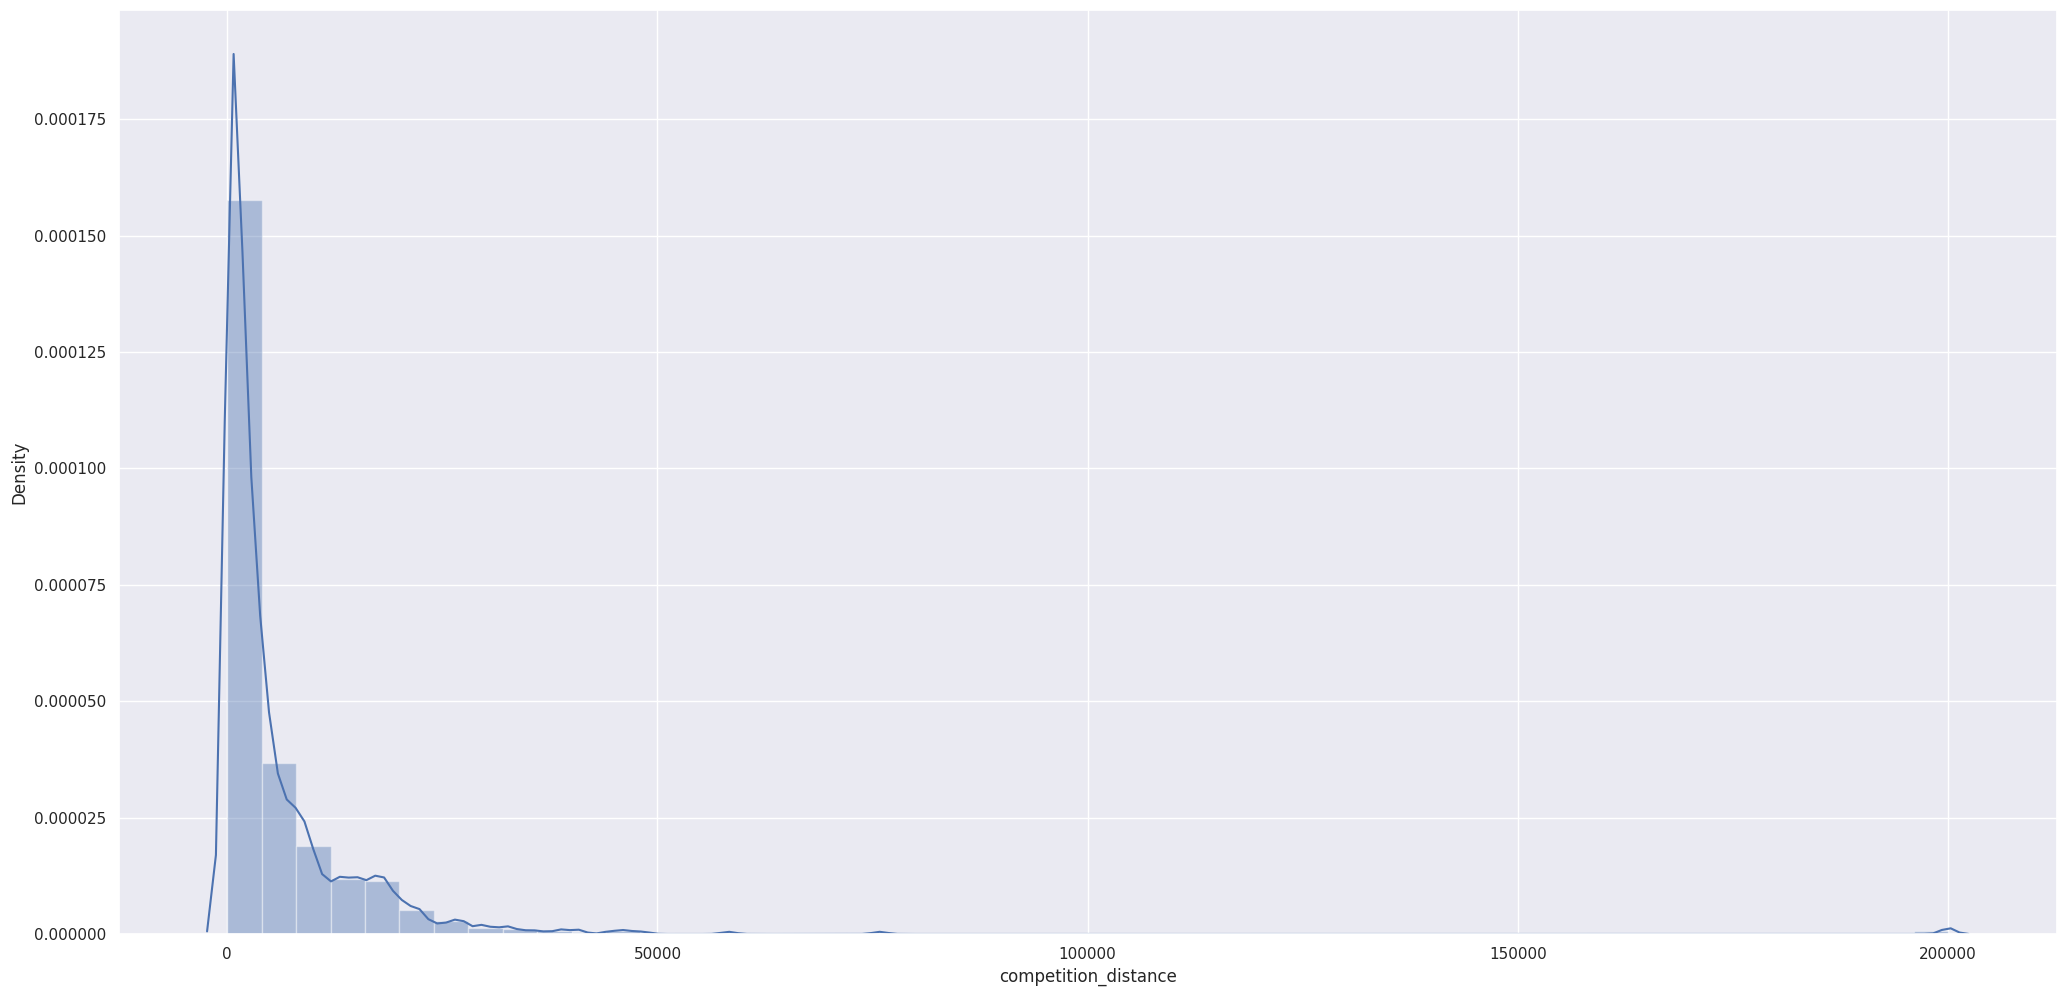

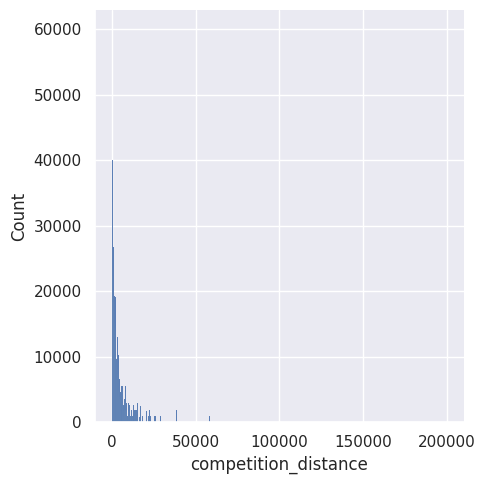

In [19]:
sns.distplot(df1['competition_distance'])
sns.displot(df1['competition_distance'])
sns.histplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='state_holiday', ylabel='sales'>

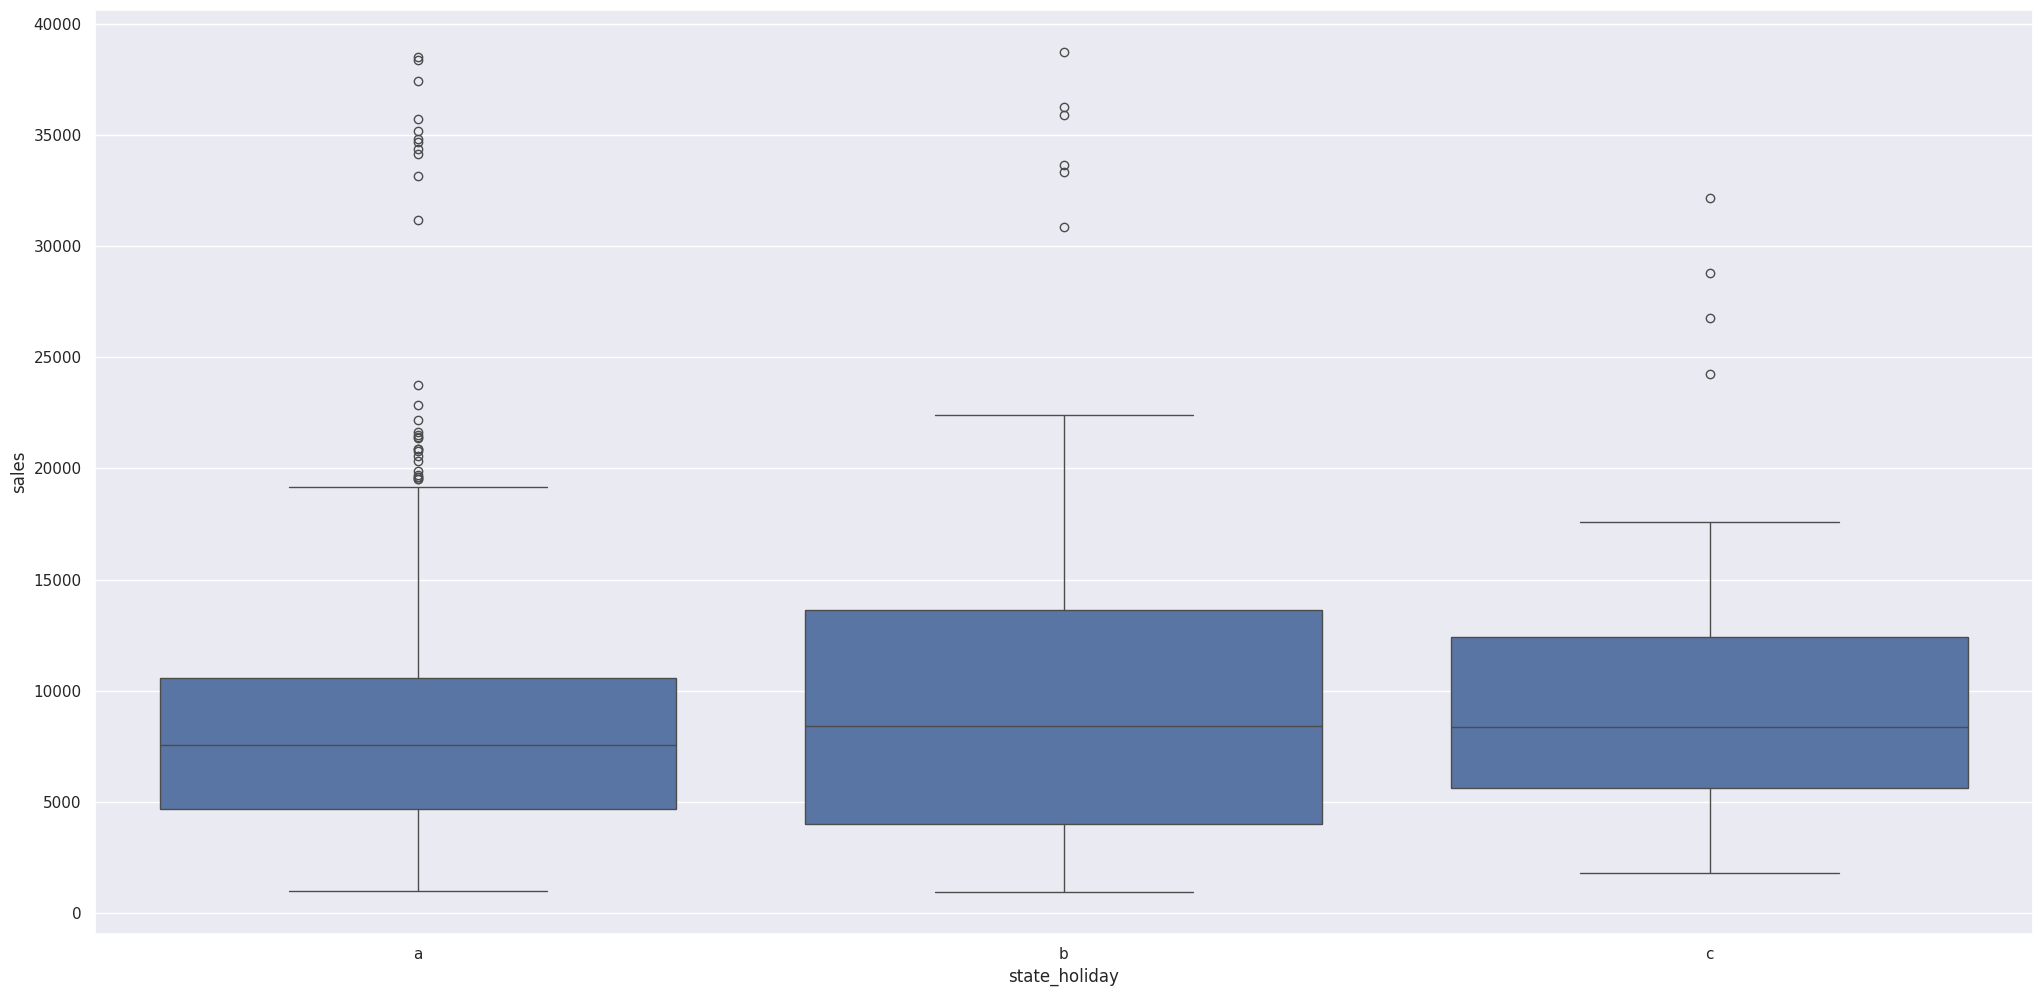

In [21]:
aux1 = df1[(df1['state_holiday'] != '0') &  (df1['sales'] > 0)]
# plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)



<Axes: xlabel='store_type', ylabel='sales'>

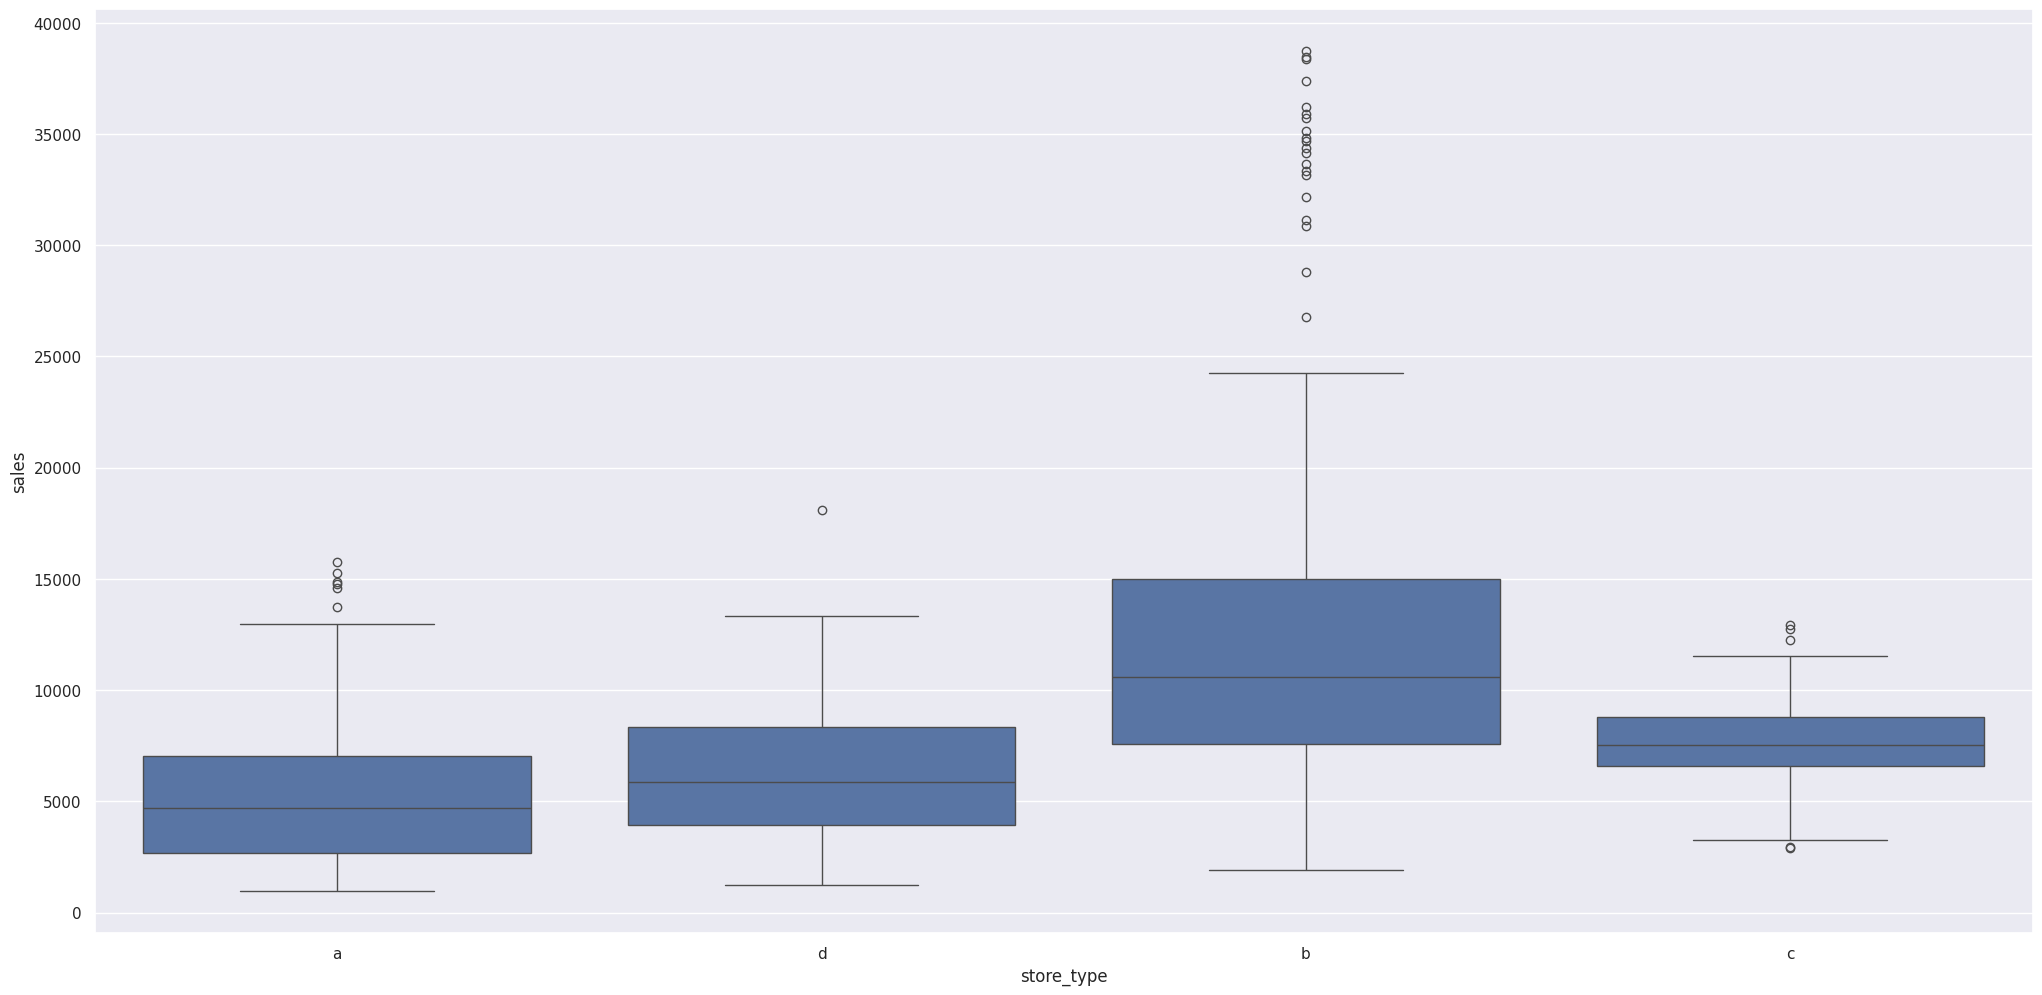

In [22]:
# plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)


<Axes: xlabel='assortment', ylabel='sales'>

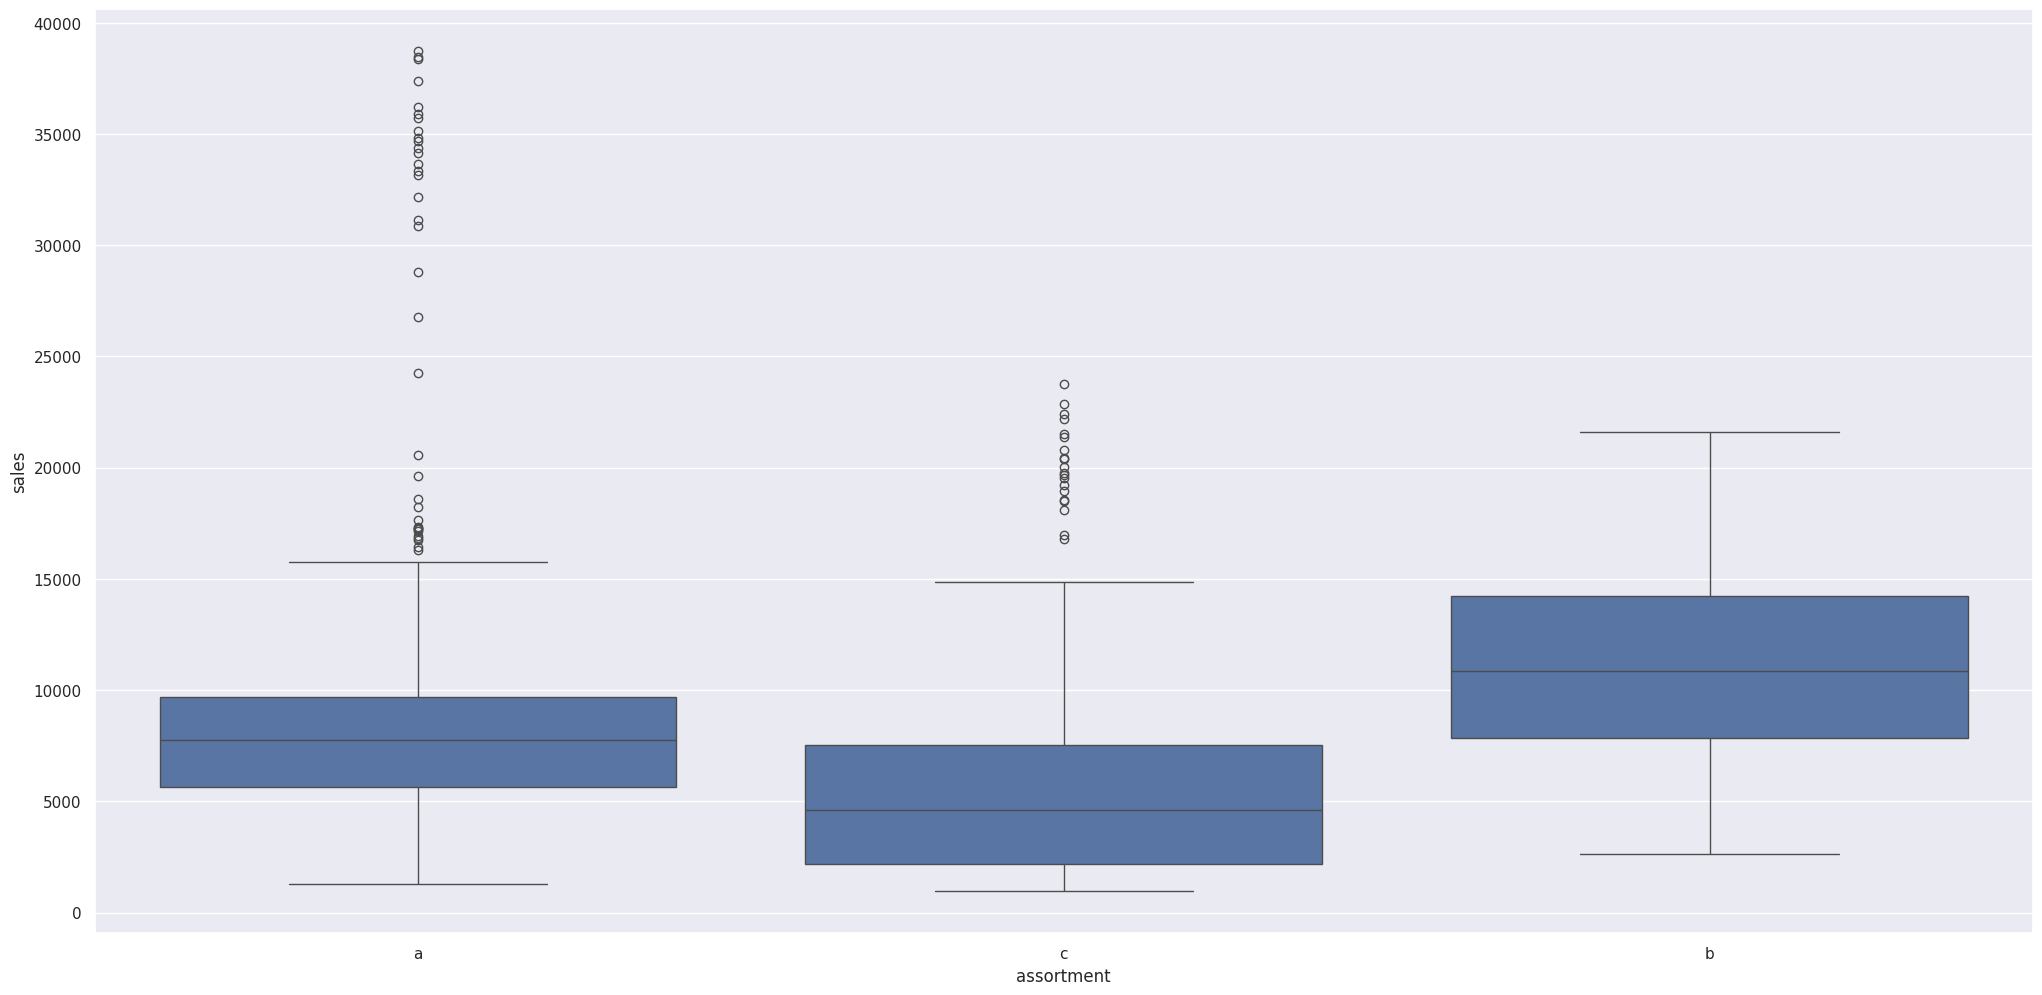

In [23]:

# plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. Feature Engineering

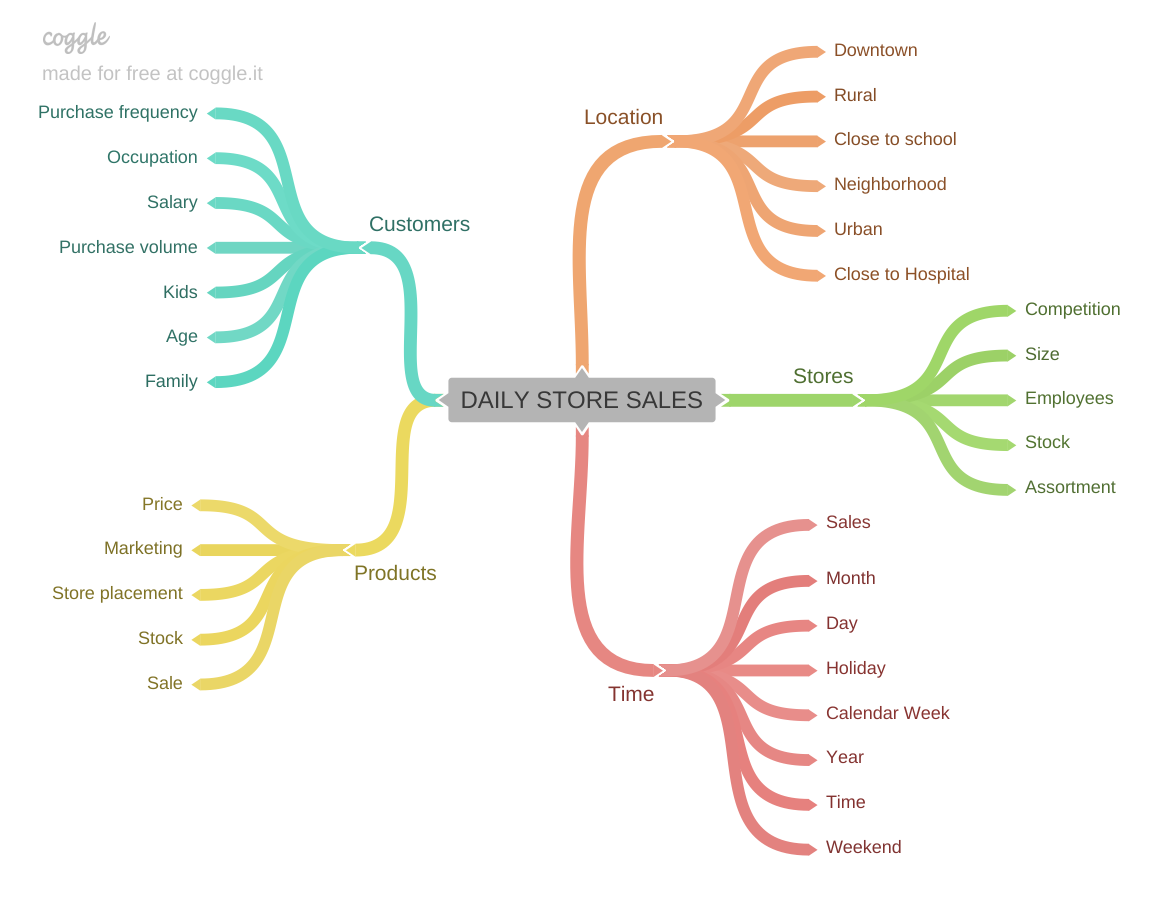

In [24]:

Image('img/Mindmaphypothesis.png')

## 2.1. Criacao de Hipteses

## 2.1.1 Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais proximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

## 2.1.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketion deveriam vender mais.

**2.** Lojas que expoem mais o produto deveriam vender mais.

**3.** Lojas com precos menores deveriam vender mais.

**4.** Lojas com precos menores por mais tempo deveriam vender mais.

**5.** Lojas com promocoes agressivas(descontos maiores) deveriam vender mais.

**6.** Lojas com mais dias de promocao deveriam vender mais.

**7.** Lojas com mais promocoes consecutivas deveriam vender mais.


## 2.1.3 Hipoteses Tempo

**1.** Lojas abertaas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos (Store age ).

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5.** Lojas deveriam vender menos aos fins de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Lista Final de Hipoteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promocoes agressivas(descontos maiores) deveriam vender mais.

**5.** Lojas com mais dias de promocao deveriam vender mais.

**6.** Lojas com mais promocoes consecutivas deveriam vender mais.

**7.** Lojas abertaas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos (Store age ).

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11.** Lojas deveriam vender menos aos fins de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


In [25]:
df2 = df1.copy()

## 2.3. Feature Engineering

In [26]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of the year
# df2['week_of_year'] = df2['date'].dt.weekofyear
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month']= ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/ 7).apply(lambda x: x.days).astype(int)
                                              
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x : 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
# stateholiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x : 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')



In [27]:
df2.sample(20).T

,856793,609644,54558,933393,282039,768750,605289,641869,647183,928264,775429,251814,884391,540508,170453,263925,856561,17843,770883,1011227
store,144,525,1039,924,936,186,630,415,154,255,175,566,982,519,974,513,1027,4,89,708
day_of_week,5,3,6,7,4,7,7,2,4,4,1,1,2,2,7,2,6,3,5,7
date,2013-05-24 00:00:00,2014-01-01 00:00:00,2015-06-13 00:00:00,2013-03-17 00:00:00,2014-11-13 00:00:00,2013-08-11 00:00:00,2014-01-05 00:00:00,2013-12-03 00:00:00,2013-11-28 00:00:00,2013-03-21 00:00:00,2013-08-05 00:00:00,2014-12-15 00:00:00,2013-04-30 00:00:00,2014-03-04 00:00:00,2015-03-01 00:00:00,2014-12-02 00:00:00,2013-05-25 00:00:00,2015-07-15 00:00:00,2013-08-09 00:00:00,2013-01-06 00:00:00
sales,7700,0,8341,0,6842,0,0,8155,8476,5684,5359,9410,8711,5183,0,22486,10240,11126,5382,0
customers,767,0,1037,0,867,0,0,585,725,614,738,813,746,545,0,2329,1406,1377,533,0
open,1,0,1,0,1,0,0,1,1,1,1,1,1,1,0,1,1,1,1,0
promo,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,1,0,1,0,0
state_holiday,regular_day,public_holiday,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
store_type,a,d,a,a,a,a,a,d,d,c,c,a,d,c,a,a,a,c,a,c


# 3.0. Passo 03 - Filtragem de Variaveis

In [28]:
df3 = df2.copy()
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [29]:
df3.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
367253,1083,4,2014-08-14,4252,292,1,0,regular_day,1,d,extended,11540.0,8,2014,1,5,2013,"Feb,May,Aug,Nov",Aug,1,2014,8,14,33,2014-32,2014-08-01,0,2013-01-28,80
267170,1039,6,2014-11-29,12769,1563,1,0,regular_day,0,a,extended,70.0,6,1990,1,22,2012,"Mar,Jun,Sept,Dec",Nov,0,2014,11,29,48,2014-47,1990-06-01,298,2012-05-21,131
88027,1058,4,2015-05-14,0,0,0,0,public_holiday,0,a,extended,180.0,5,2015,1,35,2010,"Mar,Jun,Sept,Dec",May,0,2015,5,14,20,2015-19,2015-05-01,0,2010-08-23,246
28179,305,1,2015-07-06,5629,569,1,0,regular_day,0,c,extended,2470.0,2,2005,1,31,2013,"Mar,Jun,Sept,Dec",Jul,0,2015,7,6,28,2015-27,2005-02-01,126,2013-07-29,101
339059,918,6,2014-09-13,2738,302,1,0,regular_day,0,a,extended,18710.0,4,2015,0,37,2014,0,Sep,0,2014,9,13,37,2014-36,2015-04-01,-7,2014-09-08,0


## 3.1. Filtragem das linhas 

In [30]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]


## 3.2. Selecao das Colunas 

In [31]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [32]:
df3.sample(5)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
437573,164,3,2014-06-04,7386,1,regular_day,0,a,basic,1160.0,9,2005,1,13,2010,0,2014,6,4,23,2014-22,2005-09-01,106,2010-03-22,219
968250,101,3,2013-02-13,5891,0,regular_day,0,d,extended,2440.0,2,2013,1,22,2012,0,2013,2,13,7,2013-06,2013-02-01,0,2012-05-21,38
168276,1027,2,2015-03-03,17469,1,regular_day,0,a,extended,190.0,6,2008,1,40,2011,0,2015,3,3,10,2015-09,2008-06-01,82,2011-09-26,179
148320,26,5,2015-03-20,7465,1,regular_day,0,d,basic,2300.0,3,2015,0,12,2015,0,2015,3,20,12,2015-11,2015-03-01,0,2015-03-16,0
686366,312,4,2013-10-24,5163,1,regular_day,1,d,basic,11300.0,3,2012,0,43,2013,0,2013,10,24,43,2013-42,2012-03-01,20,2013-10-21,0


In [33]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. Passo 04 - Analise exploratoria dos dados


In [34]:
df4 = df3.copy()

In [35]:
df4.sample(5)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
184121,147,1,2015-02-16,10001,1,regular_day,0,d,extended,8540.0,2,2015,0,8,2015,0,2015,2,16,8,2015-07,2015-02-01,0,2015-02-16,0
540387,398,2,2014-03-04,6474,1,regular_day,0,c,extended,1540.0,3,2014,1,1,2012,0,2014,3,4,10,2014-09,2014-03-01,0,2011-12-26,114
206522,248,2,2015-01-27,9519,1,regular_day,0,a,extended,340.0,9,2012,1,40,2012,1,2015,1,27,5,2015-04,2012-09-01,29,2012-09-24,122
66553,769,2,2015-06-02,13097,1,regular_day,0,b,extra,840.0,6,2015,1,48,2012,0,2015,6,2,23,2015-22,2015-06-01,0,2012-11-19,132
40276,137,4,2015-06-25,7472,0,regular_day,0,a,basic,1730.0,7,2015,1,40,2014,0,2015,6,25,26,2015-25,2015-07-01,-1,2014-09-29,38


## 4.1. Analise UniVariada

### 4.1.1 Response Variable

/tmp/ipykernel_2080/816018401.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales']);


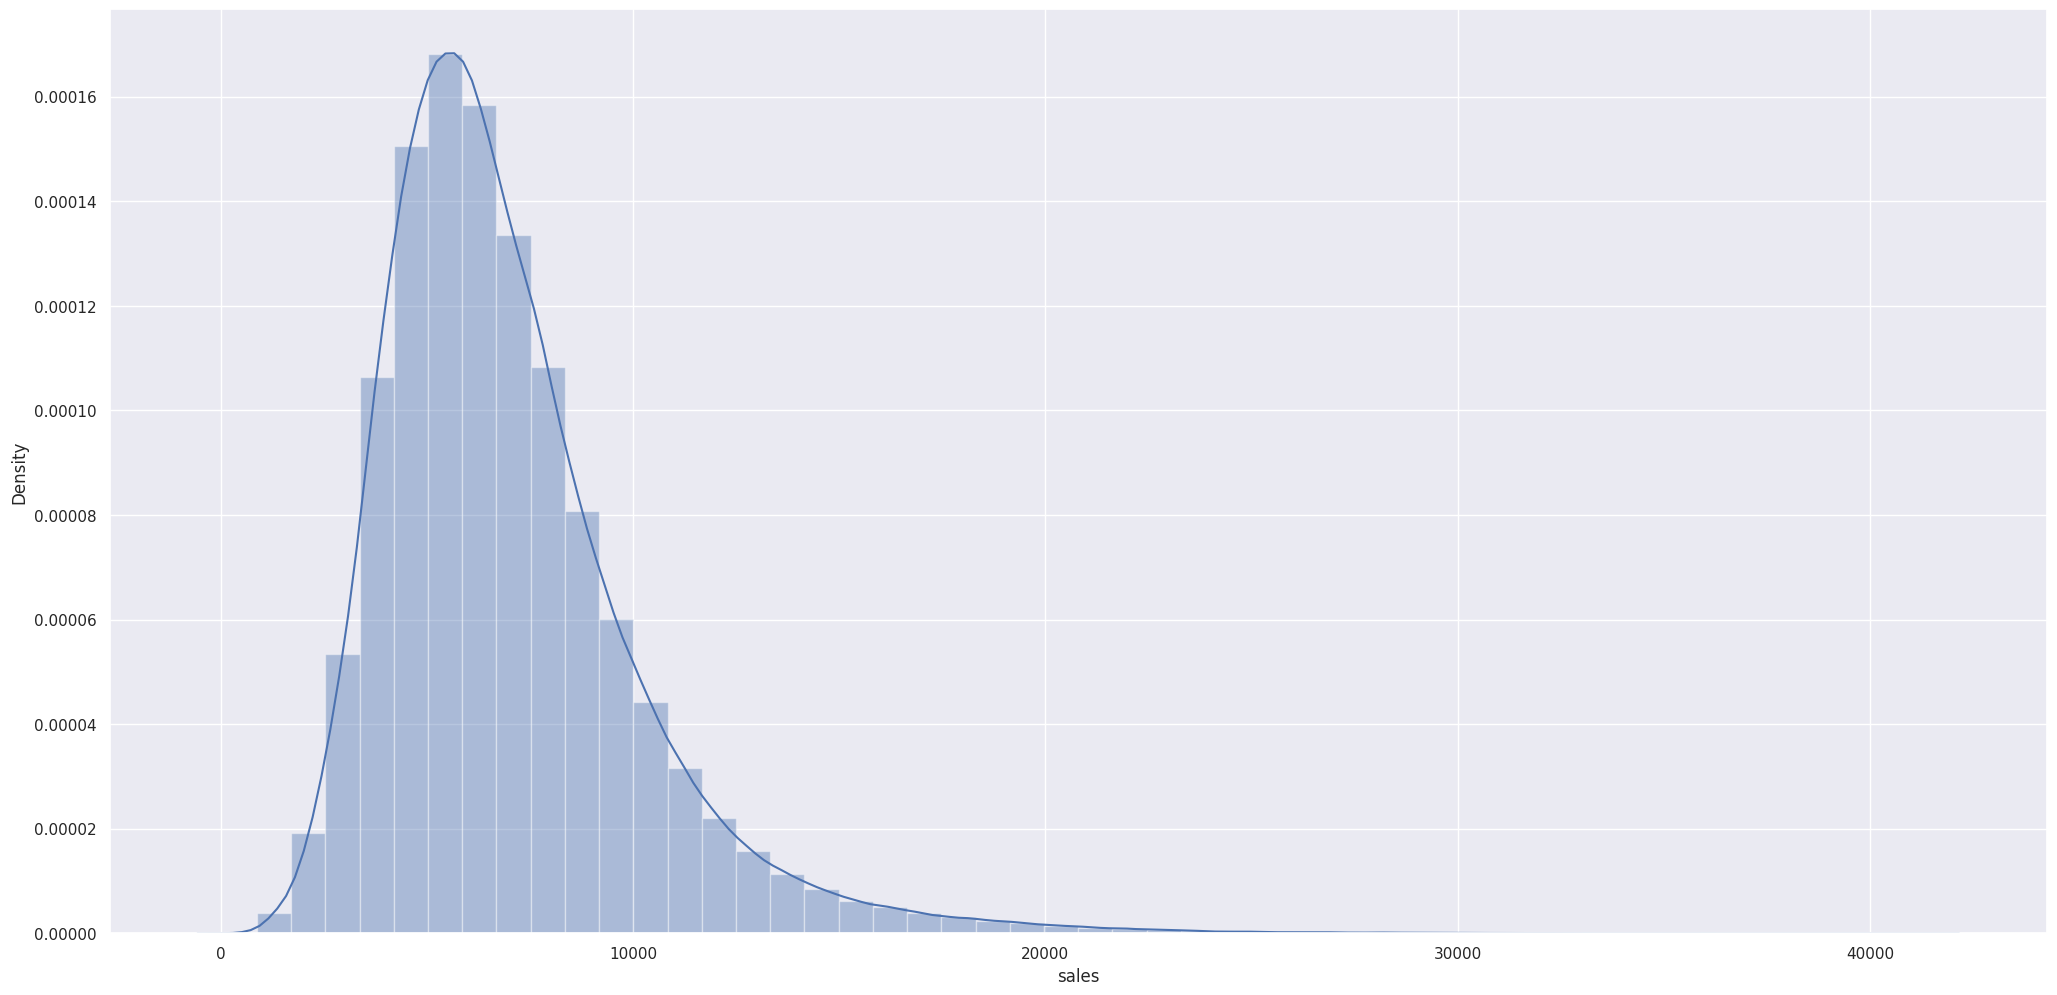

In [36]:
sns.distplot(df4['sales']);

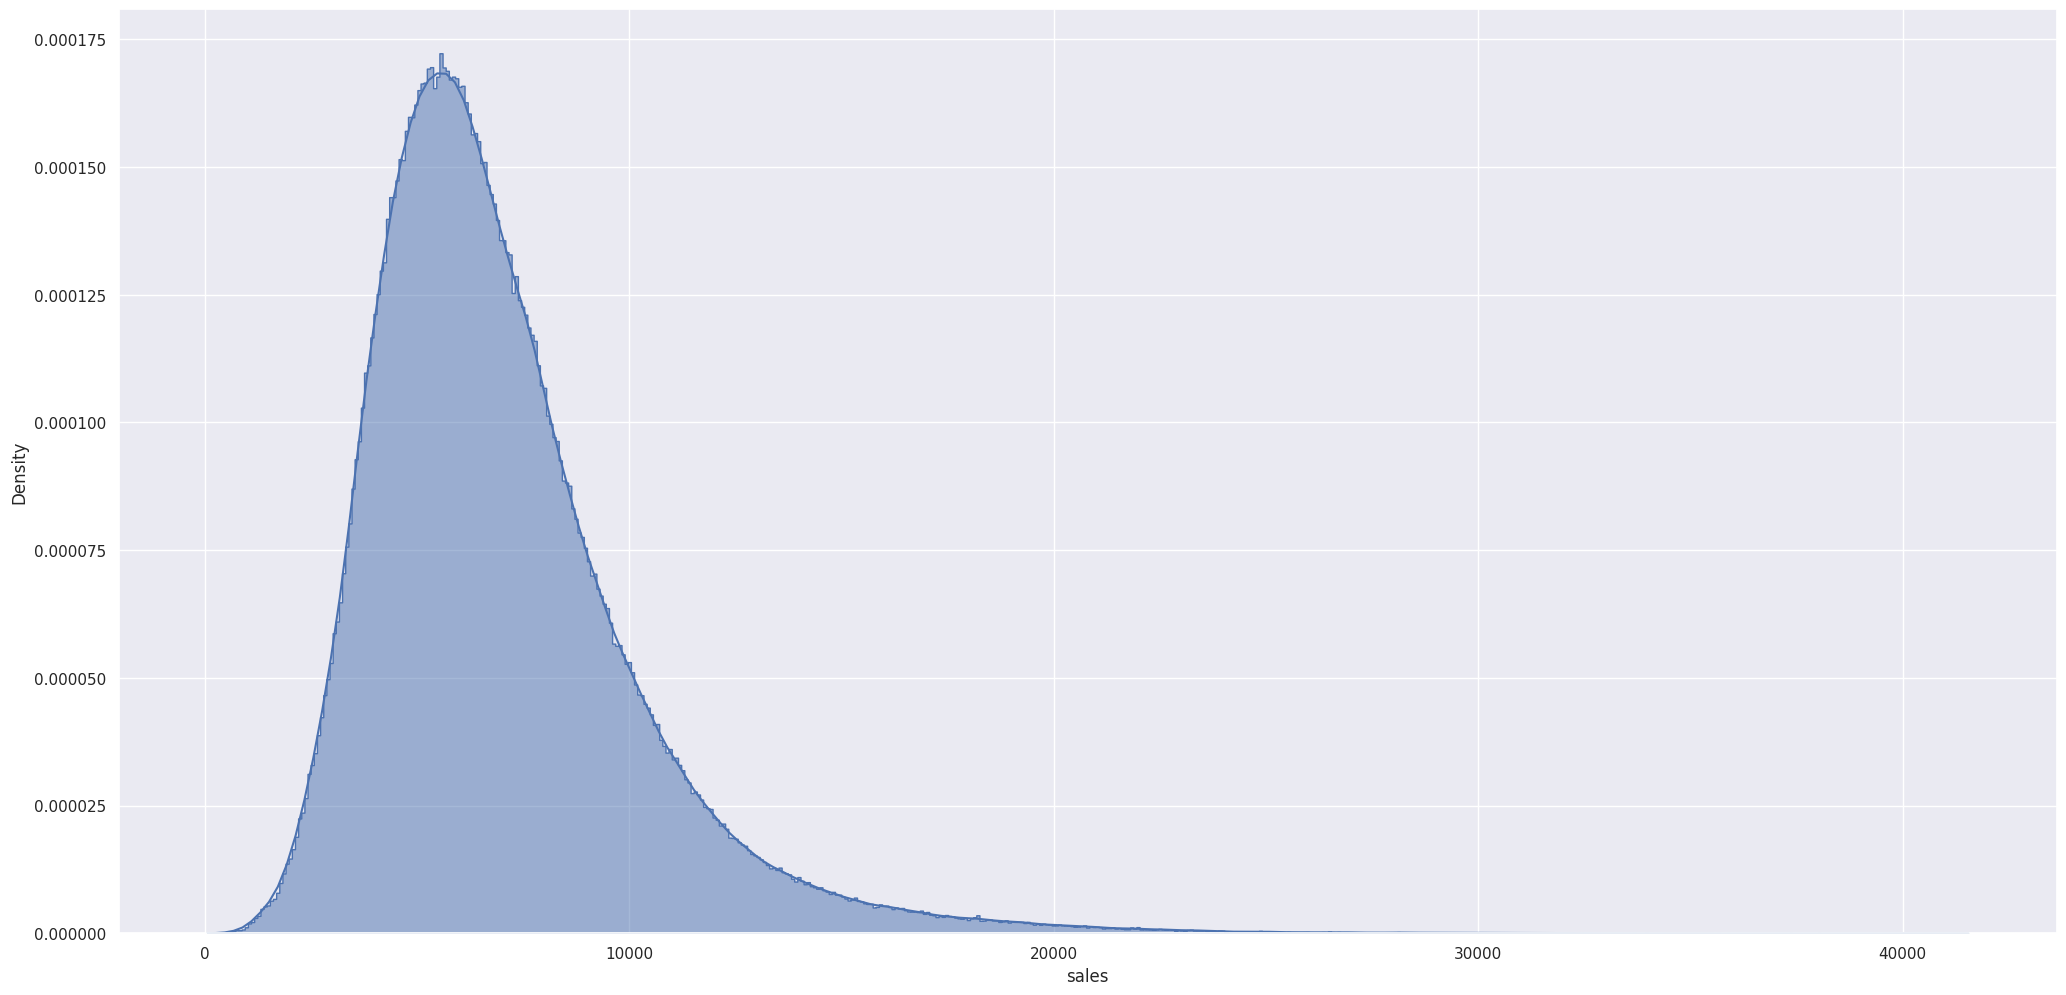

In [37]:
sns.histplot(df4['sales'], element="step", stat="density", kde=True );

### 4.1.2 Numerical Variable

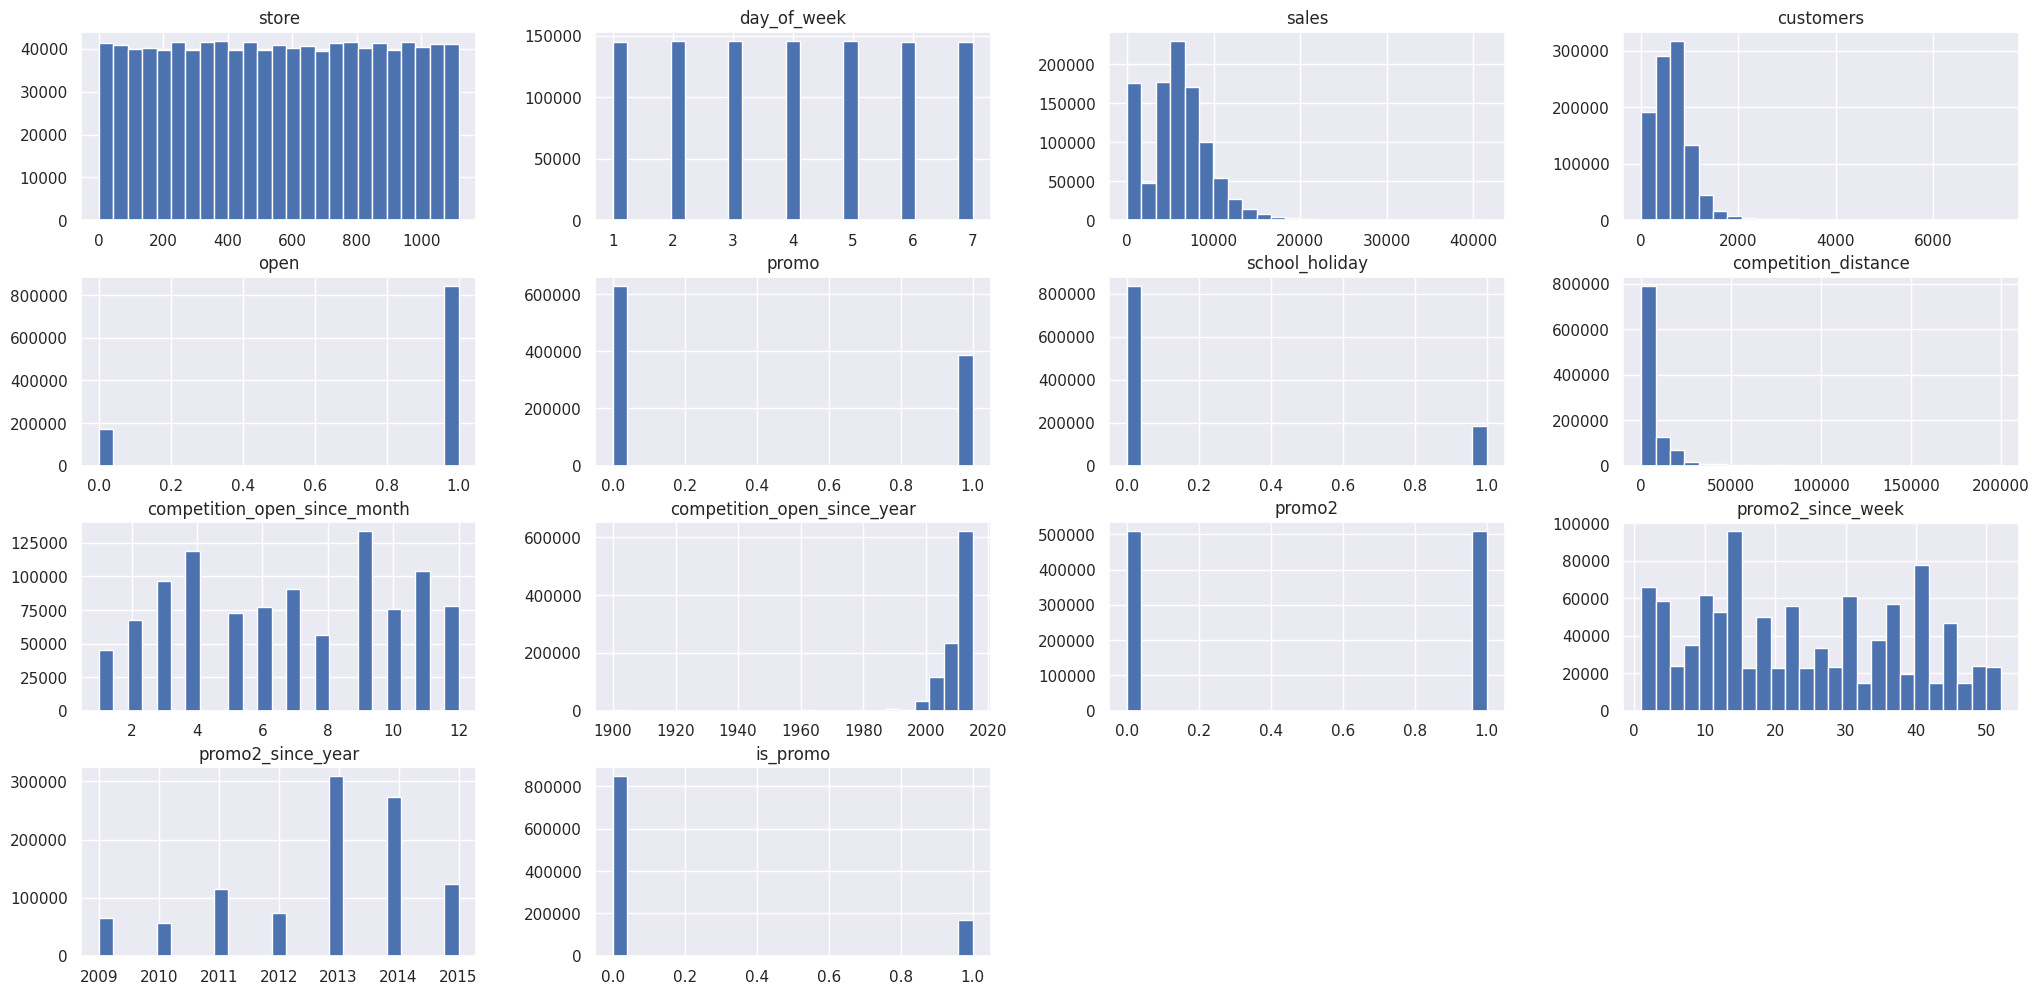

In [38]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

In [39]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<Axes: xlabel='sales', ylabel='Density'>

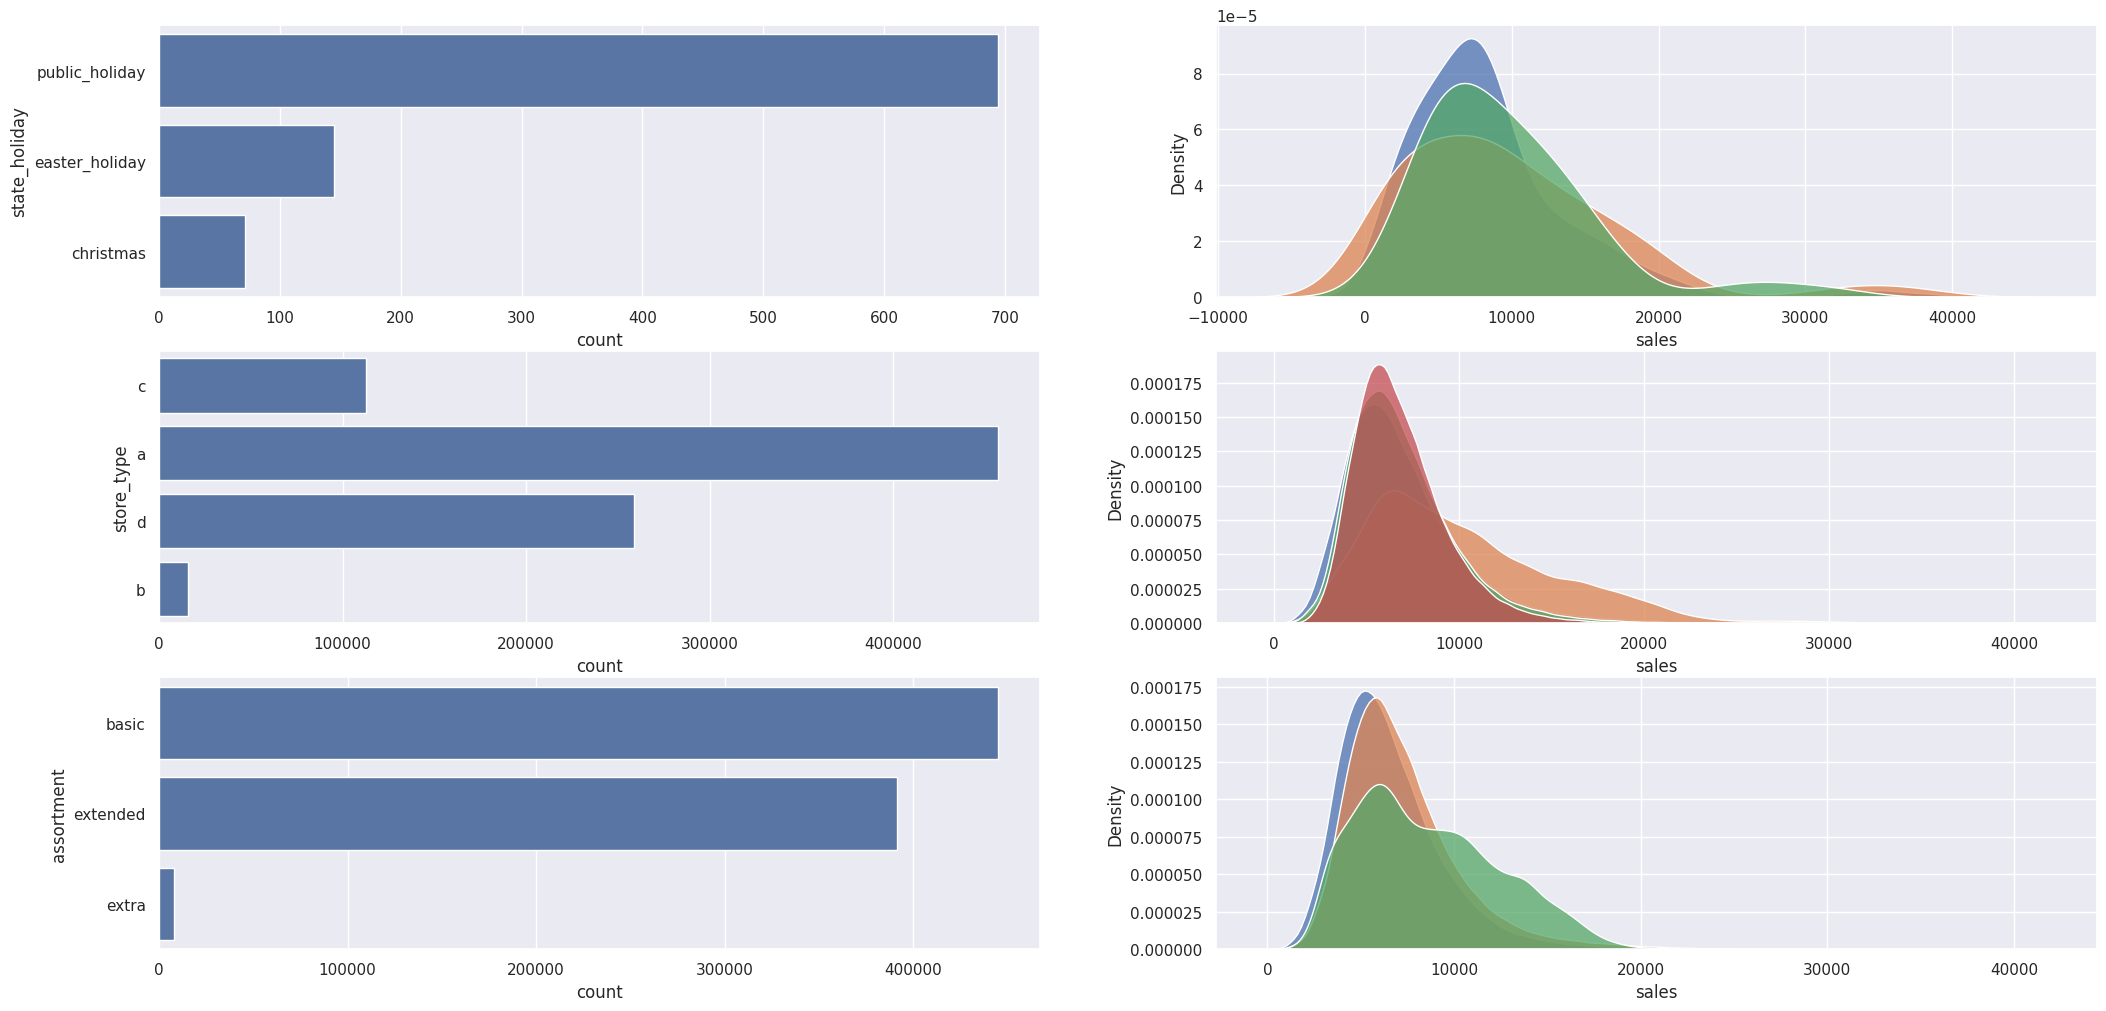

In [40]:
sns.color_palette()

# state_holiday	

plt.subplot(3, 2, 1 )
a= df4 [df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

# sns.countplot(df4['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', multiple="stack")
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', multiple="stack")
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', multiple="stack")

# store_type

plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])



plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', multiple="stack")
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', multiple="stack")
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', multiple="stack")
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', multiple="stack")

# assortment

plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])


plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', multiple="stack")
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', multiple="stack")
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', multiple="stack")



## 4.2. Analise Bivariada

### H1. Lojas com maiores sortimentos deveriam vender mais.

In [41]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

<Axes: xlabel='year_week'>

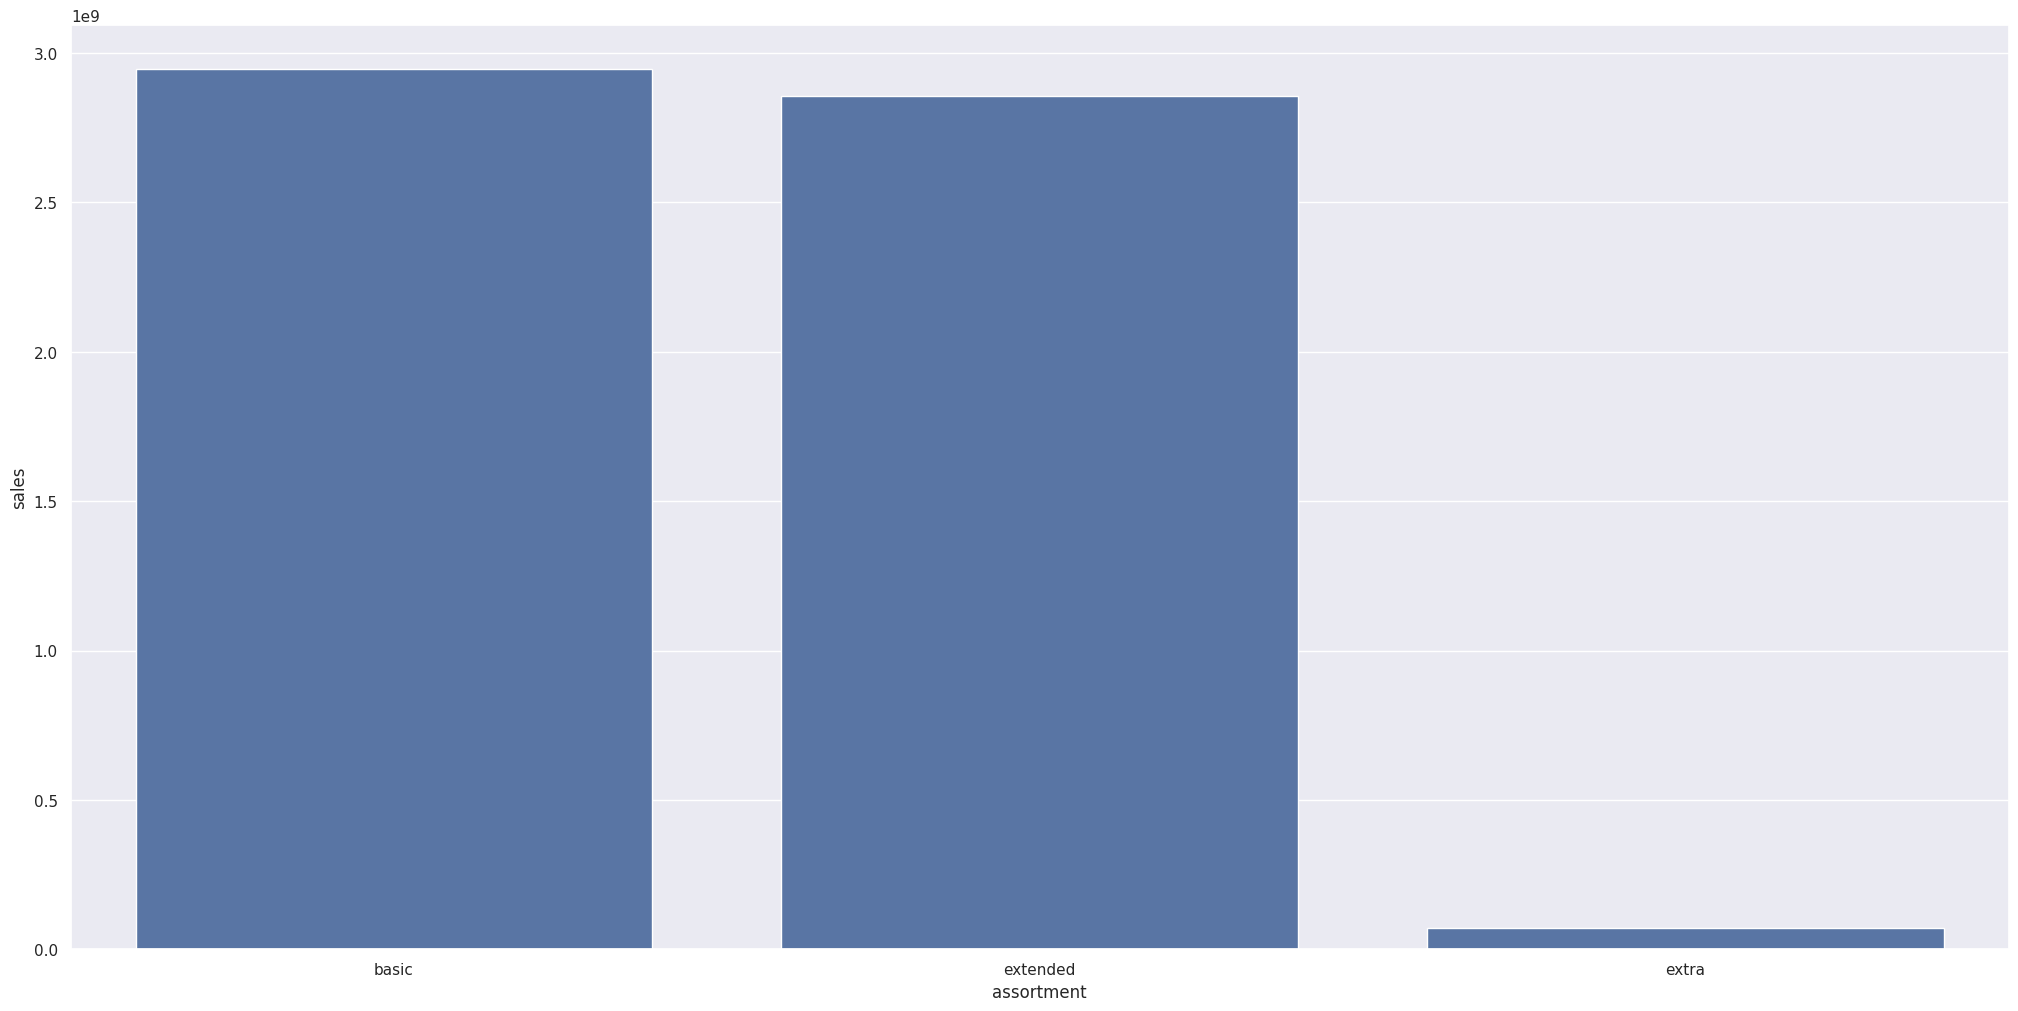

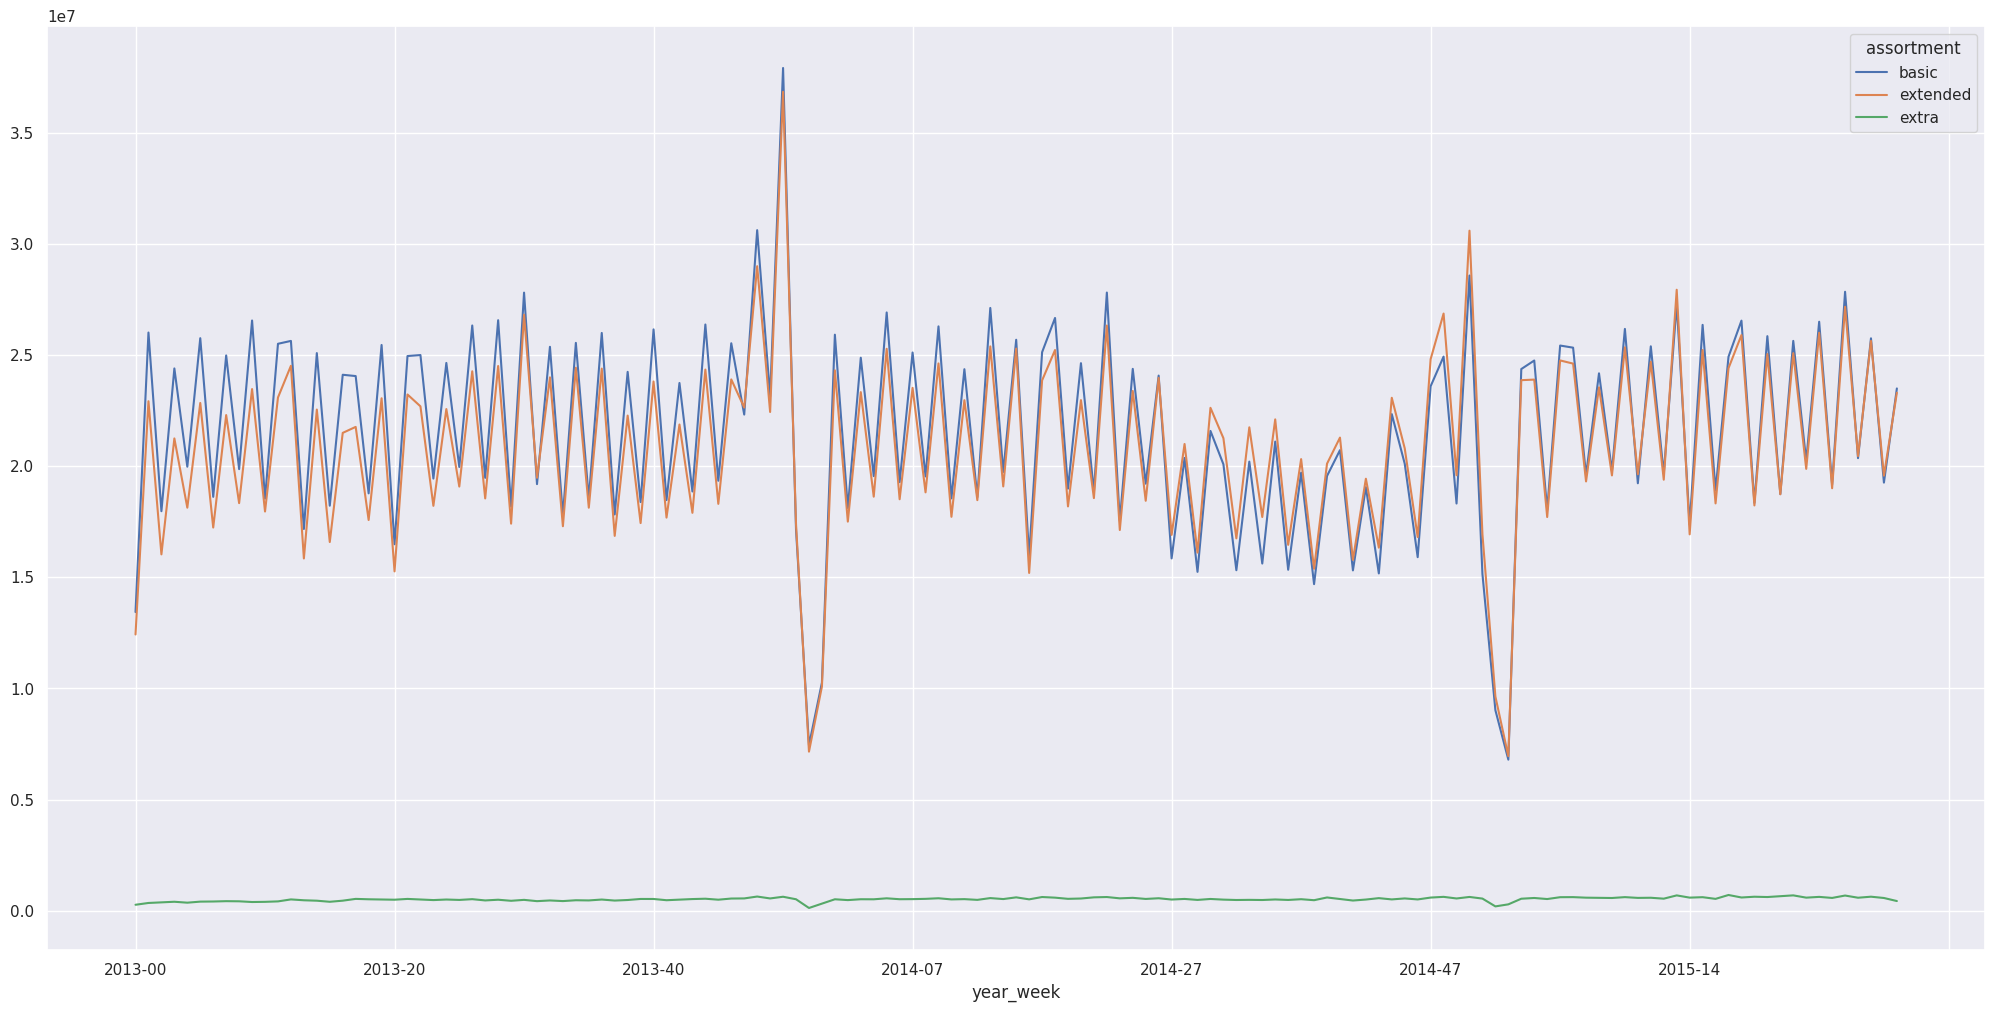

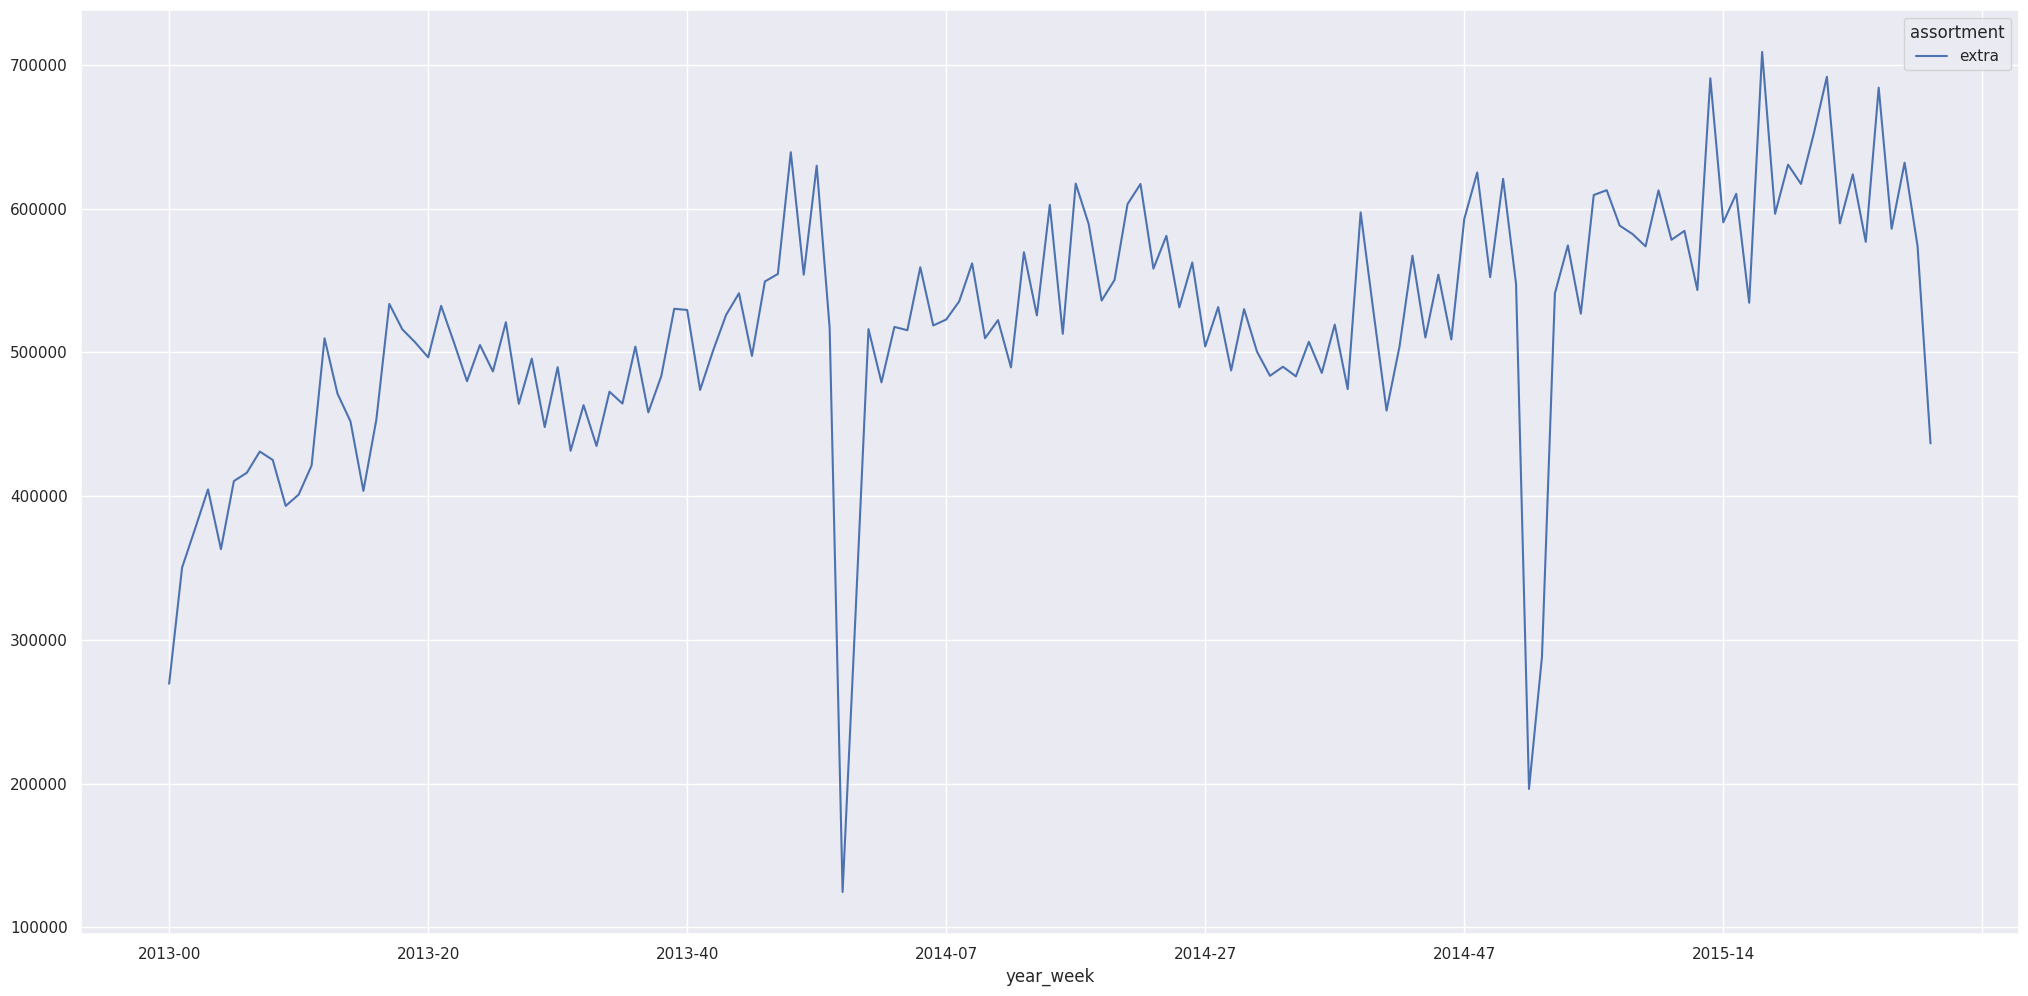

In [42]:

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x= 'assortment', y= 'sales', data=aux1);
# o extra seria os maiores assortiments

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

In [43]:
aux3.head()

,year_week,assortment,sales
2,2013-00,extra,269404
5,2013-01,extra,350279
8,2013-02,extra,377207
11,2013-03,extra,404662
14,2013-04,extra,363061


### H2. Lojas com cvompetidores mais proximos deveriam vender menos.

/tmp/ipykernel_2080/875898268.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index();


<Axes: >

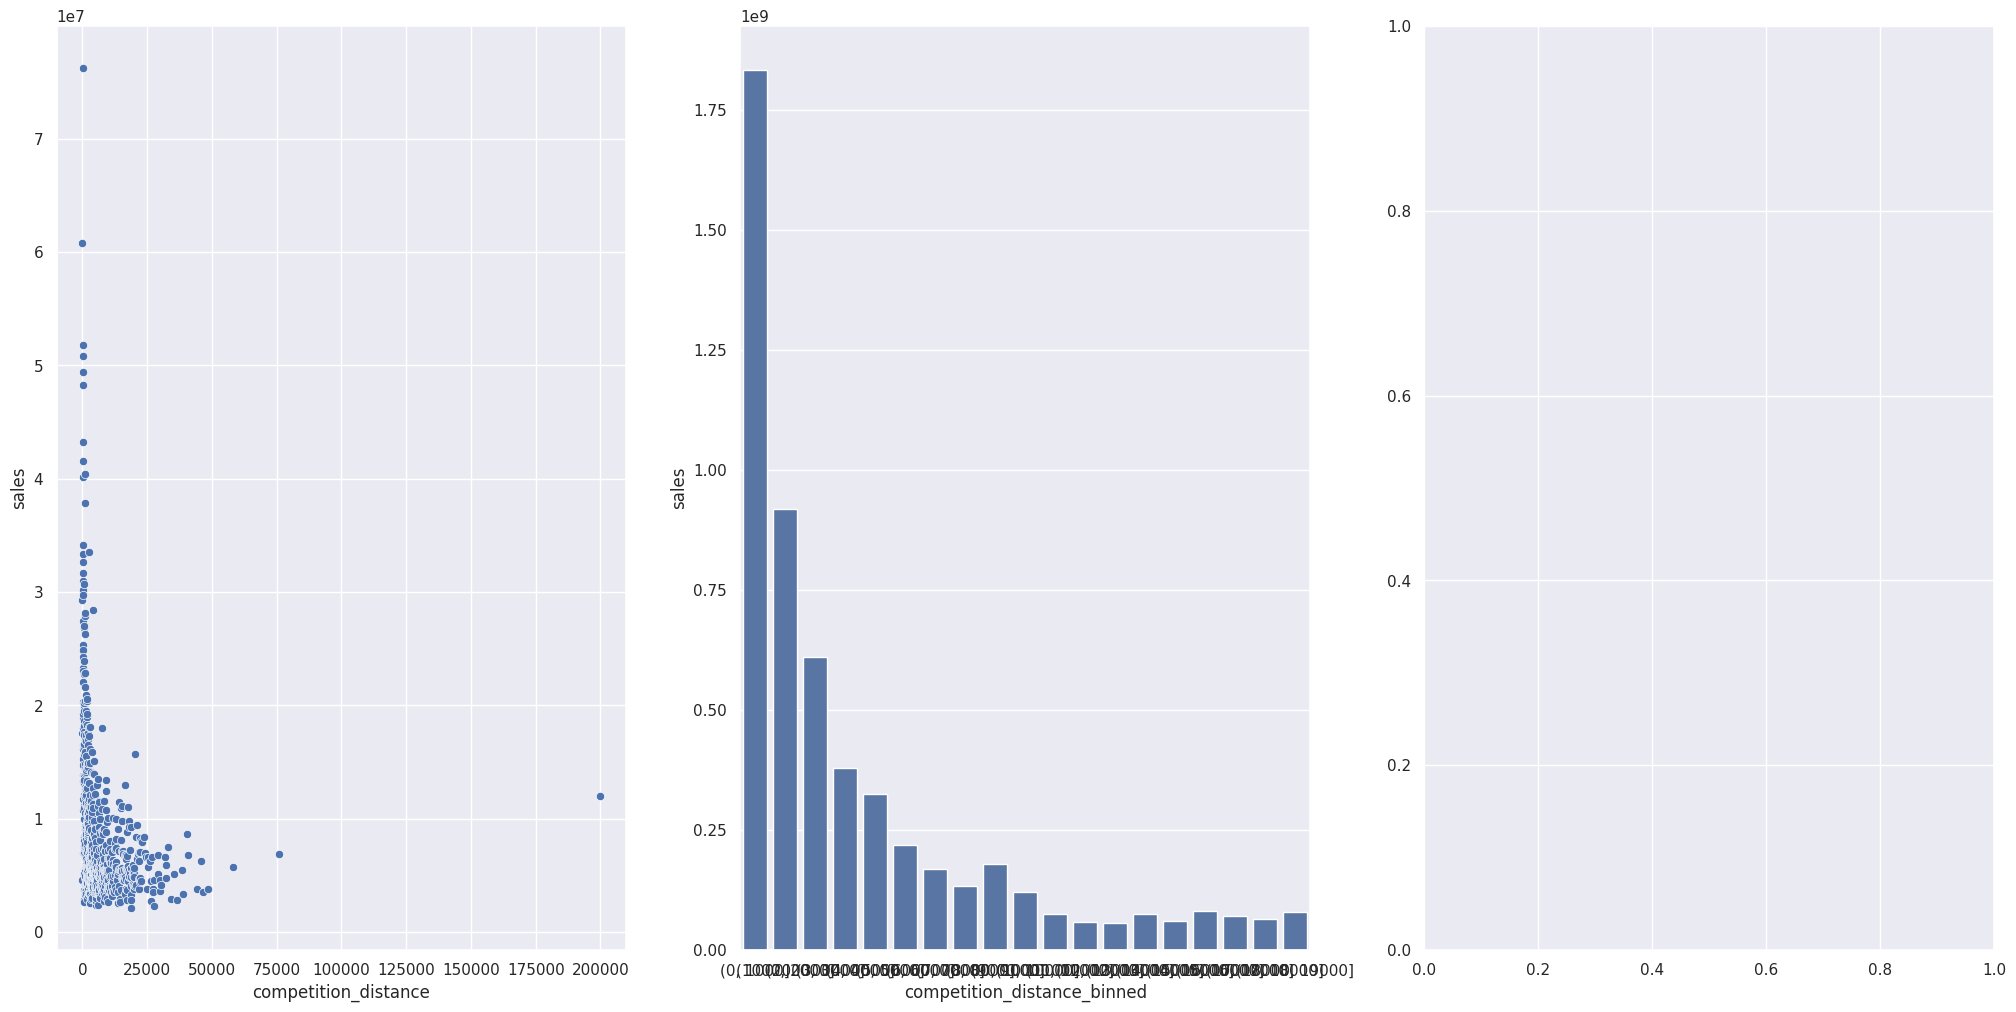

In [44]:

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot( x='competition_distance', y='sales', data=aux1)


plt.subplot(1, 3, 2)
bins = list( np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index();
sns.barplot(x= 'competition_distance_binned', y= 'sales', data=aux2);


plt.subplot(1, 3, 3)
# aux3 = aux1[aux1['competition_distance'].astype(int)]
# correlation = aux3.corr(method='pearson')
# sns.heatmap(aux3.corr( method='pearson'), annot=True);



In [45]:
# TypeError: float() argument must be a string or a number, not 'pandas._libs.interval.Interval'
# competition_distance            float64
# sales                             int64
# competition_distance_binned    category
# dtype: object

aux3.head(10)

,year_week,assortment,sales
2,2013-00,extra,269404
5,2013-01,extra,350279
8,2013-02,extra,377207
11,2013-03,extra,404662
14,2013-04,extra,363061
17,2013-05,extra,410482
20,2013-06,extra,416260
23,2013-07,extra,431015
26,2013-08,extra,425147
29,2013-09,extra,393170


### H3. Lojas com competidores à mais tempo deveriam vender mais.

In [46]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

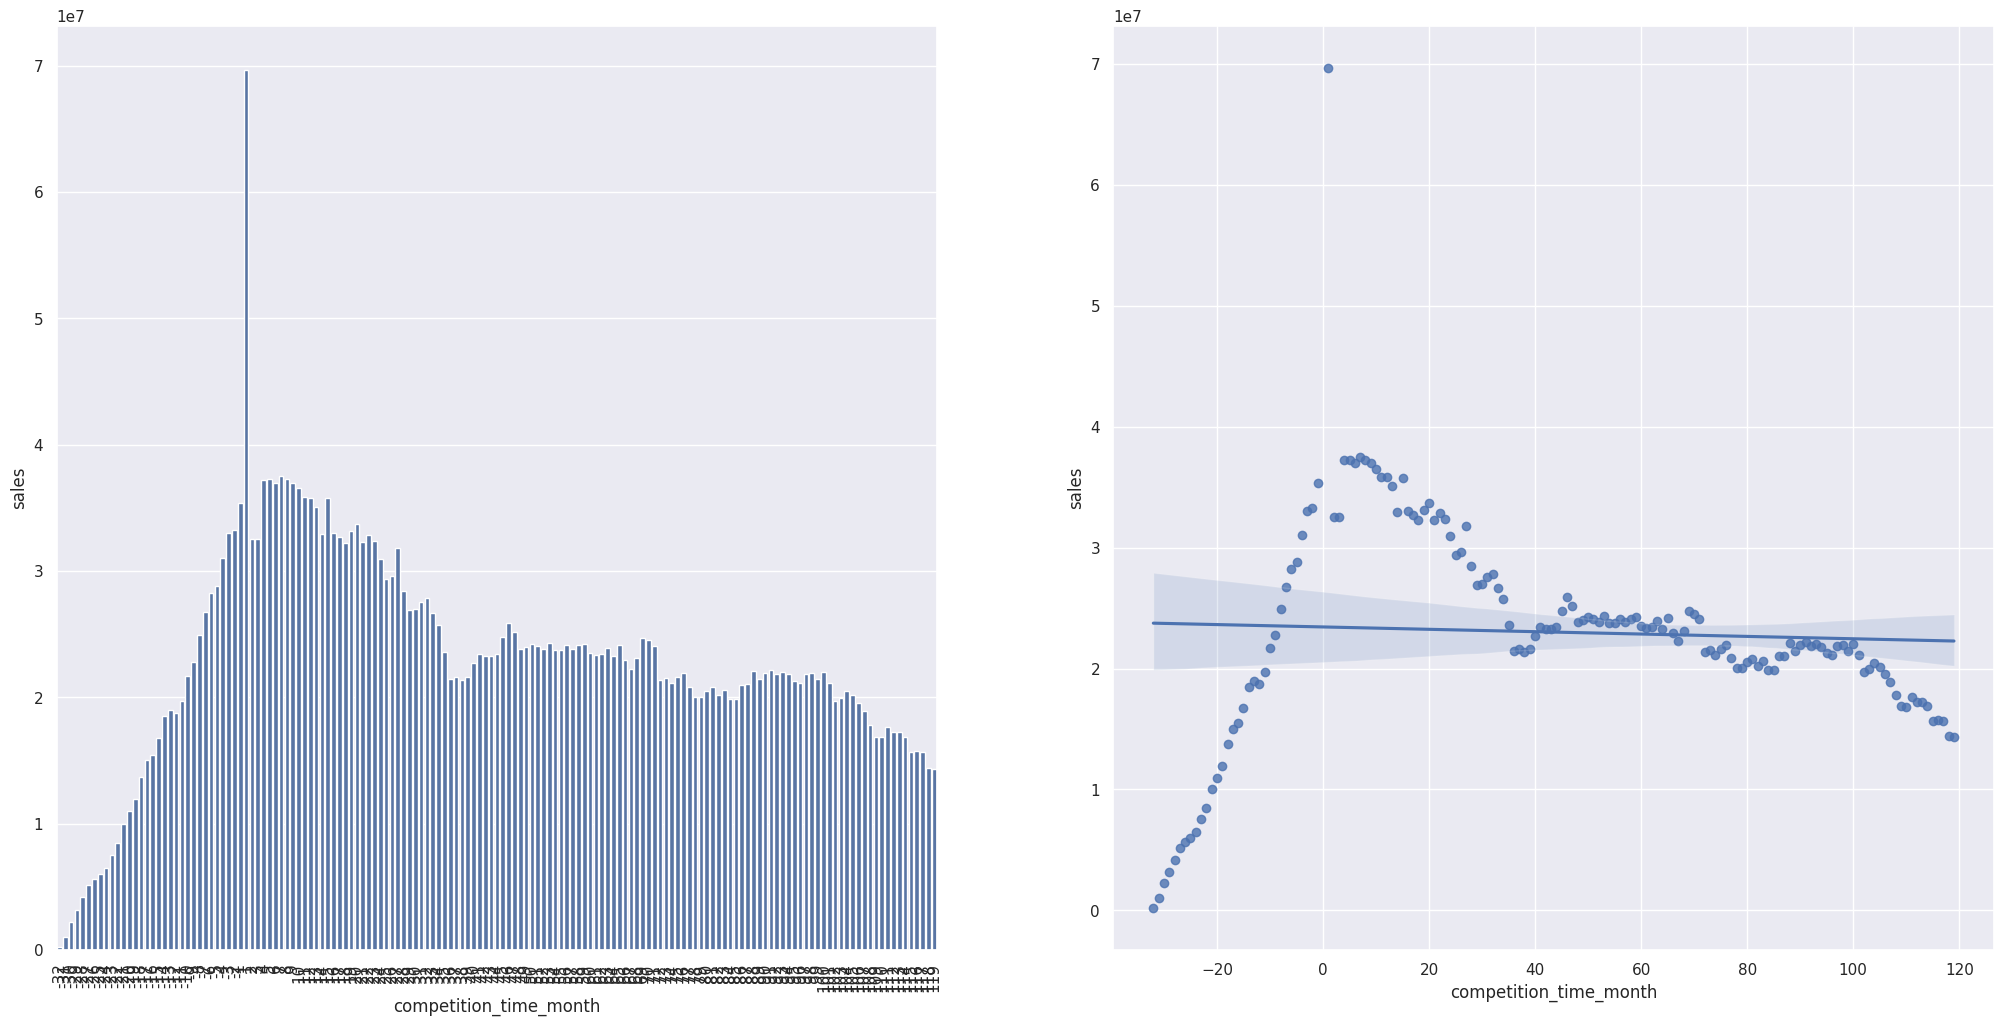

In [47]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']  < 120)  & (aux1['competition_time_month']  != 0)]



plt.subplot(1, 2, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux2 );
plt.xticks(rotation=90);

plt.subplot(1, 2, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2 );

In [48]:
aux1.head()

,competition_time_month,sales
0,-32,198200
1,-31,993663
2,-30,2232685
3,-29,3175827
4,-28,4157527


## 4.3. Analise MultiVariada

### 4.3.1 Numerical Attributes

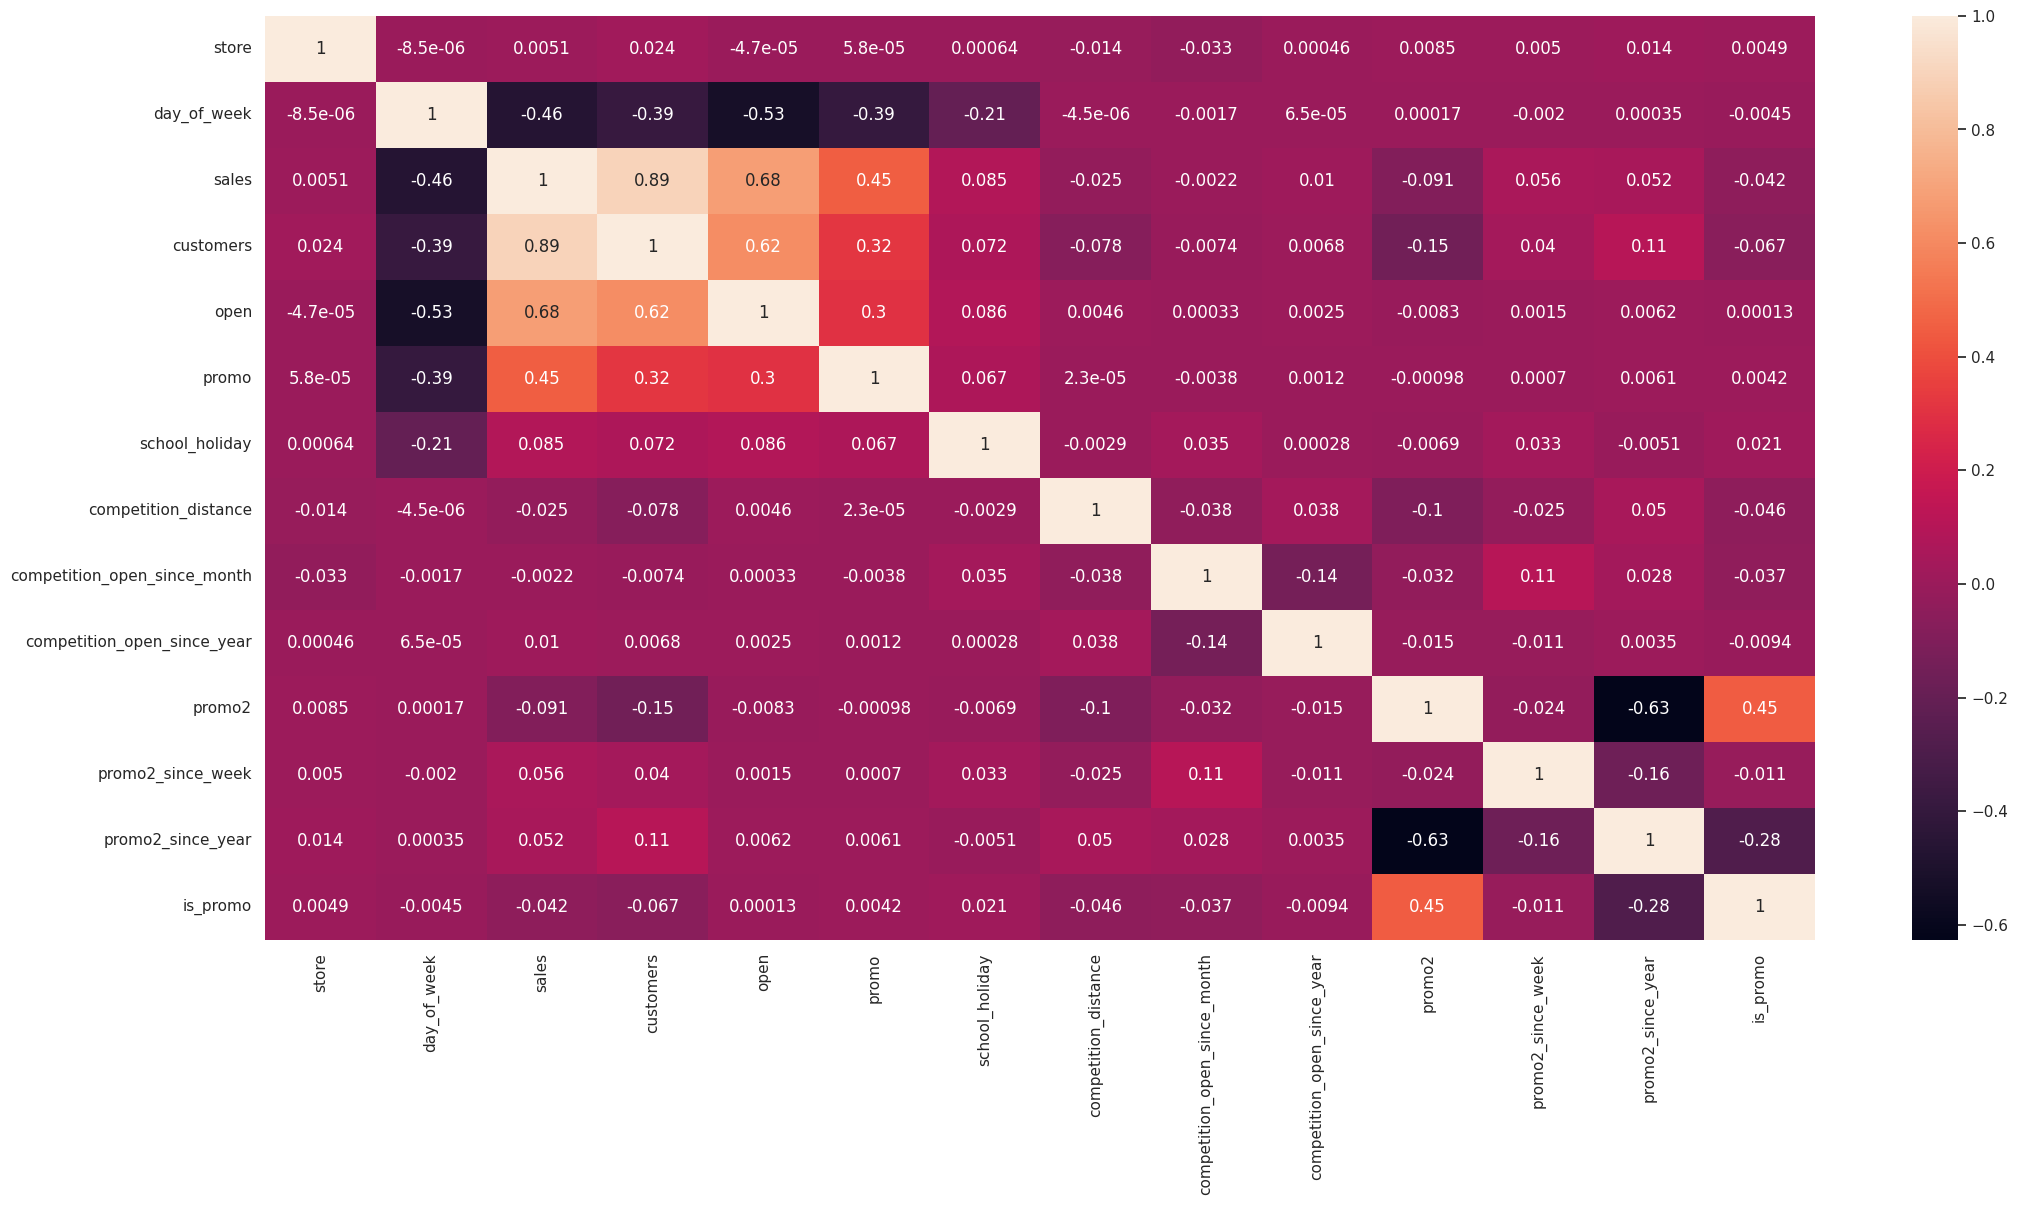

In [49]:



correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

In [50]:
a = df4.select_dtypes(include='object')
a.head()
# cat_attributes.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [51]:
cm = pd.crosstab(a['state_holiday'], a['store_type'])

In [52]:
cm

store_type,a,b,c,d
state_holiday,,,,
christmas,4,66,0,1
easter_holiday,36,100,0,9
public_holiday,236,285,65,108
regular_day,456766,15109,112903,258650


In [53]:
# cm2 = a[['state_holiday', 'store_type']].values

In [54]:
# cm2

In [55]:
# chi2 = ss.chi2_contingency( cm )[0]

# n = cm2.sum()

# r, k = cm2.shape

In [56]:
# print(chi2)
# 

In [57]:
# print(n)


In [58]:
# print(r)


In [59]:
# print(k)

In [60]:
# v = np.sqrt((chi2/n)/(min(k-1,r-1)))

In [61]:
# v

# 5.0. Passo 05 - Data Preparation

In [62]:
df5 = df4.copy()

## 5.1. Normalizacao

## 5.2. Rescaling

In [63]:
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int32
month                                    int32
day                                      int32
week_of_year                            UInt32
year_week                               object
competition_s

In [64]:
a = df5.select_dtypes(include=['int64', 'float64', 'int32', 'UInt32'])

In [65]:
a.sample(5)

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
970336,1072,2,5942,0,0,5380.0,8,2015,1,5,2010,1,2013,2,12,7,-30,159
781515,686,3,7219,1,1,20050.0,4,2002,0,31,2013,0,2013,7,31,31,137,0
328921,1086,3,3937,0,0,180.0,11,2013,1,18,2011,0,2014,9,24,39,10,178
781479,650,3,8055,1,1,1420.0,10,2012,1,40,2014,1,2013,7,31,31,10,-61
892101,887,2,6947,1,0,19700.0,4,2013,1,37,2009,1,2013,4,23,17,0,189


In [66]:
rs = RobustScaler()
mms = MinMaxScaler()
# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
# year
df5['year'] = mms.fit_transform(df5[['year']].values)

/tmp/ipykernel_2080/3675789336.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df5['competition_distance']);


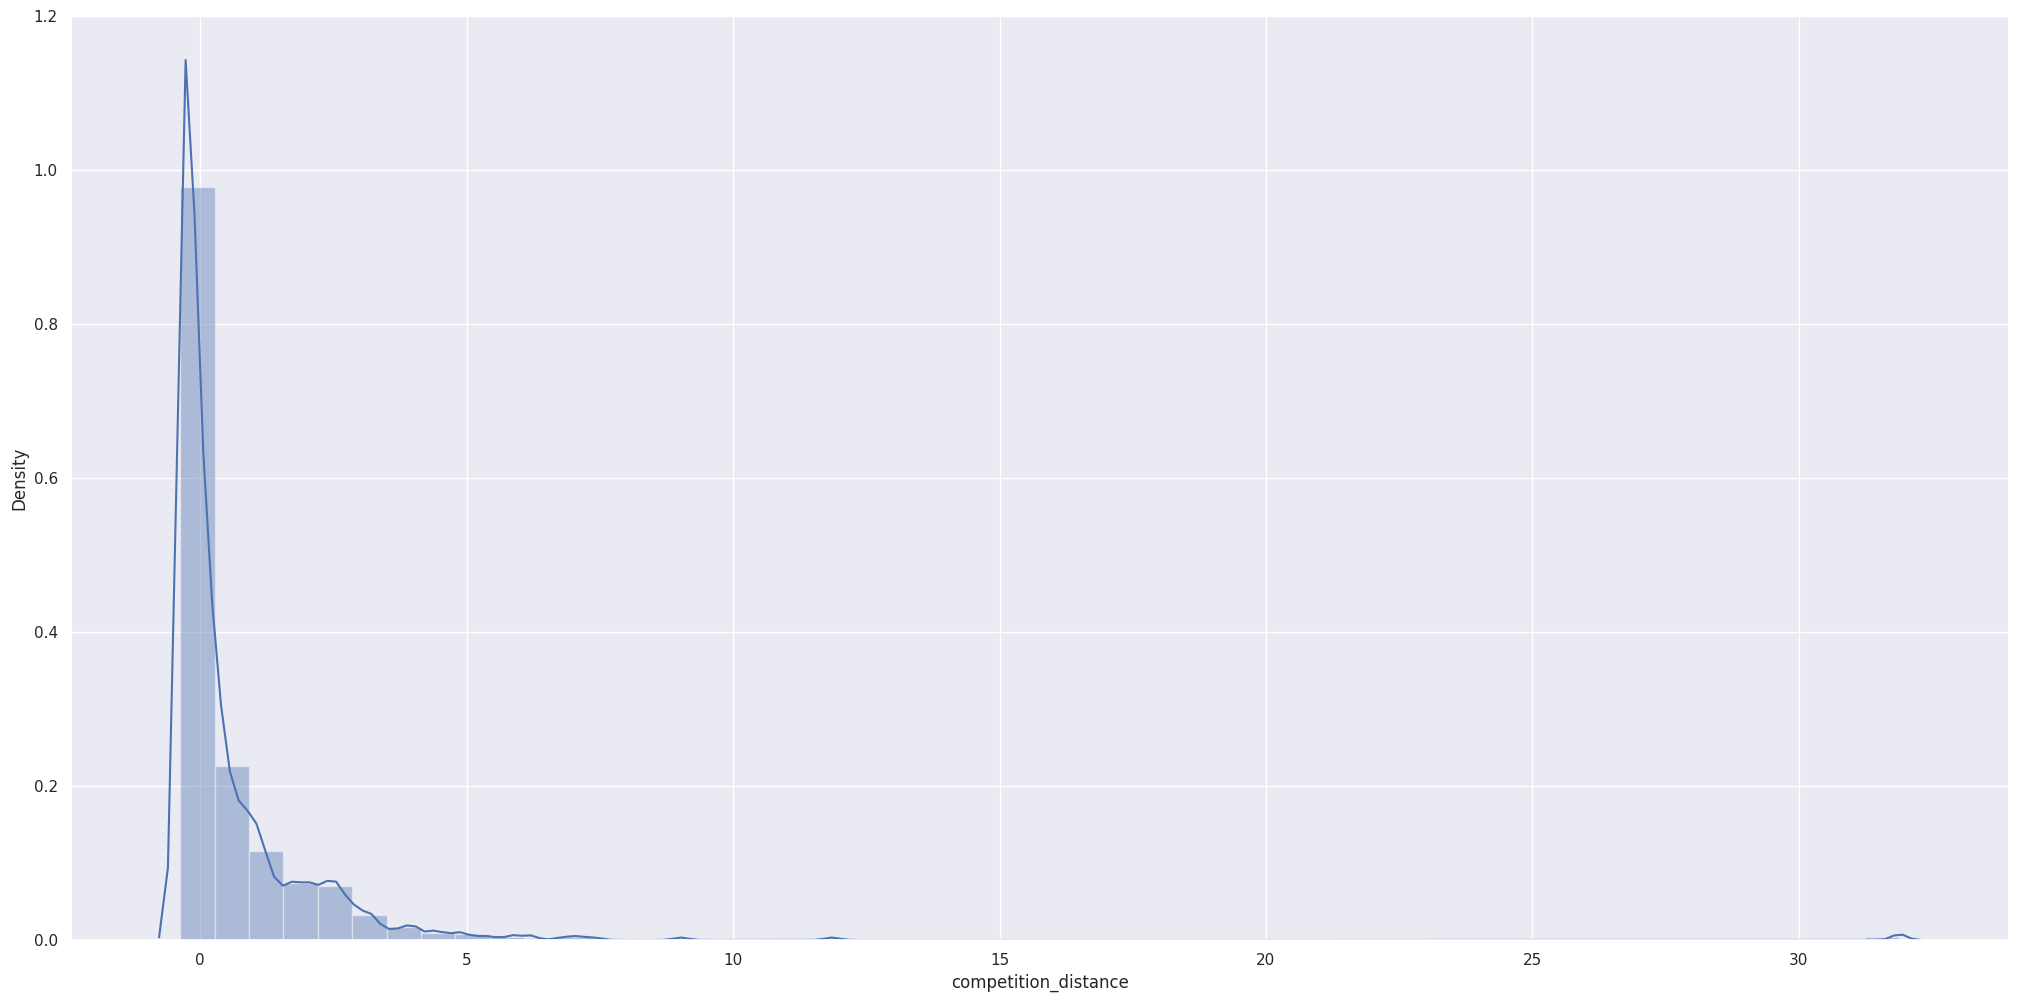

In [67]:



sns.distplot(df5['competition_distance']);

## 5.3. Transformation

### 5.3.1. Enconding

In [68]:
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                   float64
month                                    int32
day                                      int32
week_of_year                            UInt32
year_week                               object
competition_s

In [69]:
b = df5.select_dtypes(include=['object'])

In [70]:
b.sample(5)

,state_holiday,store_type,assortment,year_week
384858,regular_day,a,extended,2014-29
664689,regular_day,a,extended,2013-45
658966,regular_day,c,extended,2013-46
543619,regular_day,a,basic,2014-08
316280,regular_day,a,extended,2014-40


In [71]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
# criar um dicionario para ordenar a ordem que eu quero
assortment_dict = { 'basic' : 1, 'extra' : 2, 'extended' : 3}
df5['assortment']= df5['assortment'].map(assortment_dict)


In [72]:
c = df5.select_dtypes(include=['object'])

In [73]:
c.sample(5)

,year_week
977278,2013-05
114744,2015-16
896679,2013-15
144991,2015-12
158284,2015-10


### 5.3.2. Response Variabel Transformation

/tmp/ipykernel_2080/4056287585.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df5['sales'])


<Axes: xlabel='sales', ylabel='Density'>

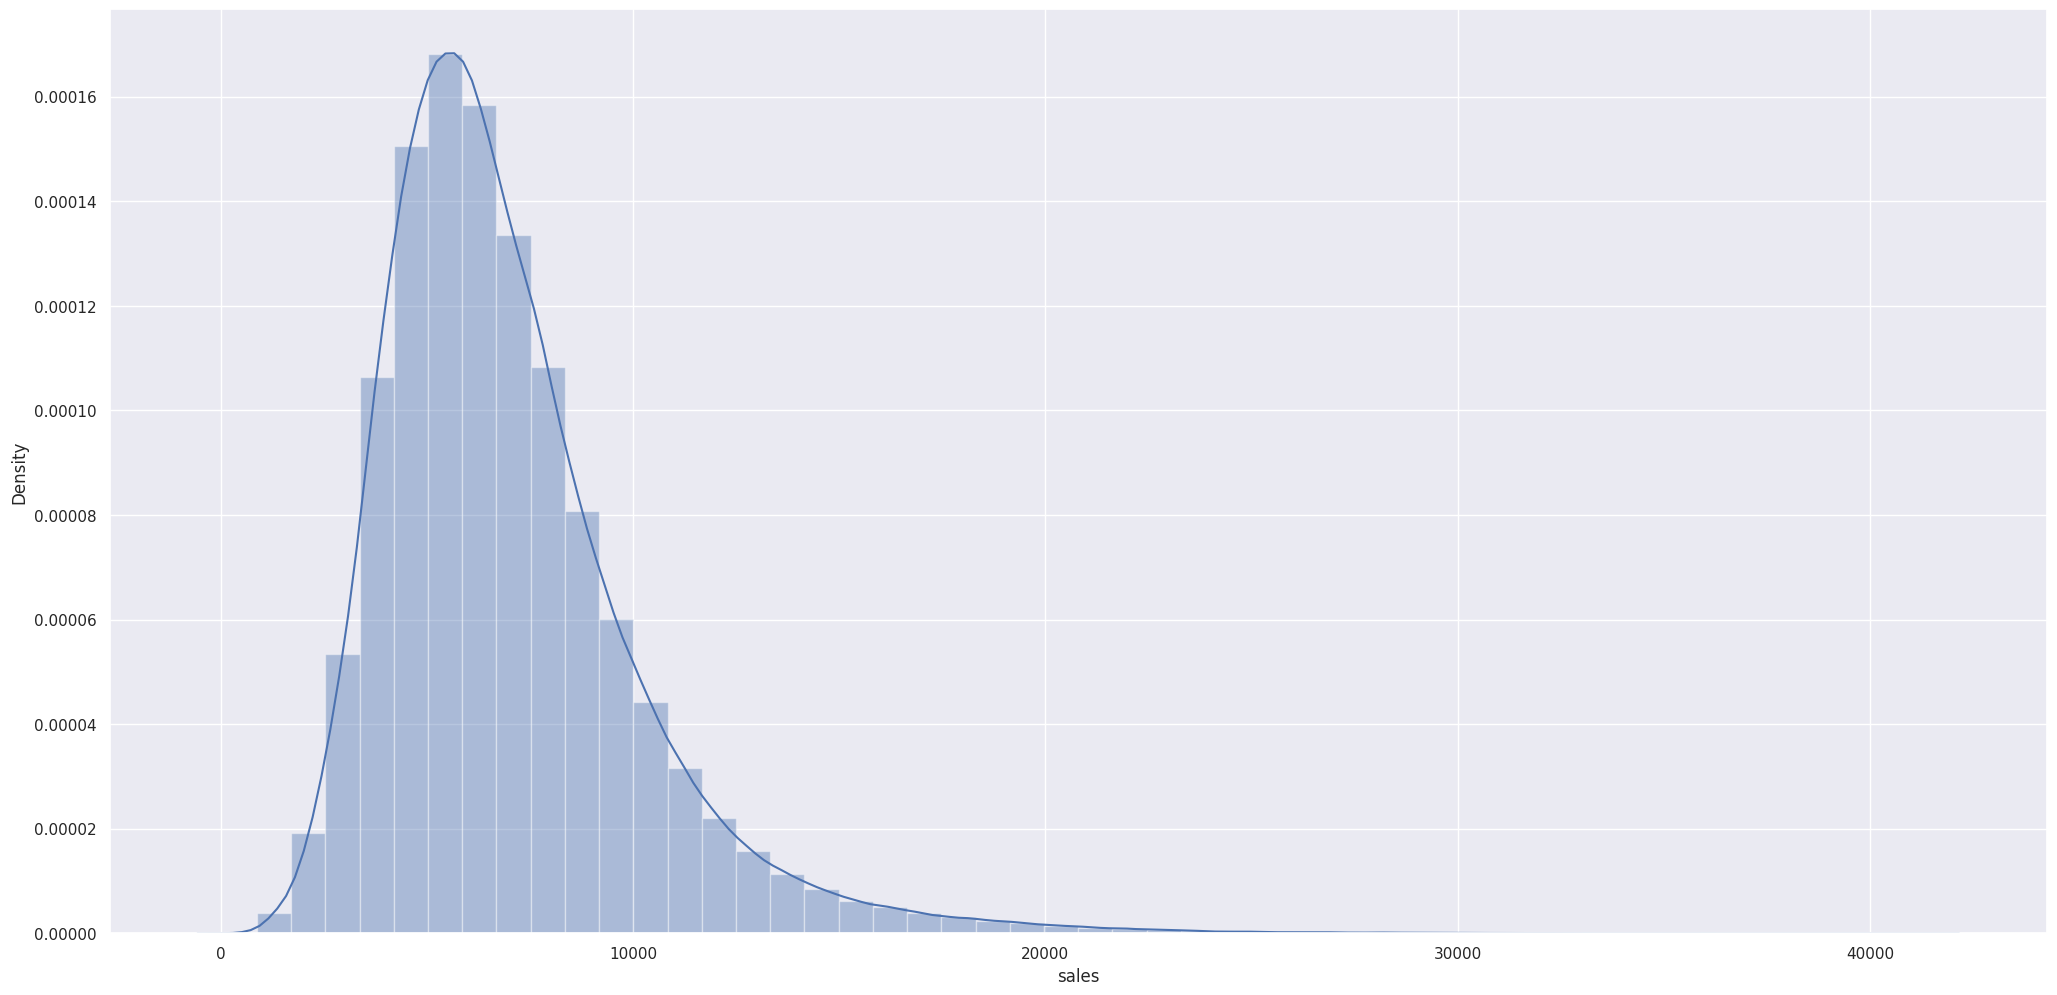

In [75]:
sns.distplot(df5['sales'])

In [76]:
df5['sales'] = np.log1p(df5['sales'])

/tmp/ipykernel_2080/4056287585.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df5['sales'])


<Axes: xlabel='sales', ylabel='Density'>

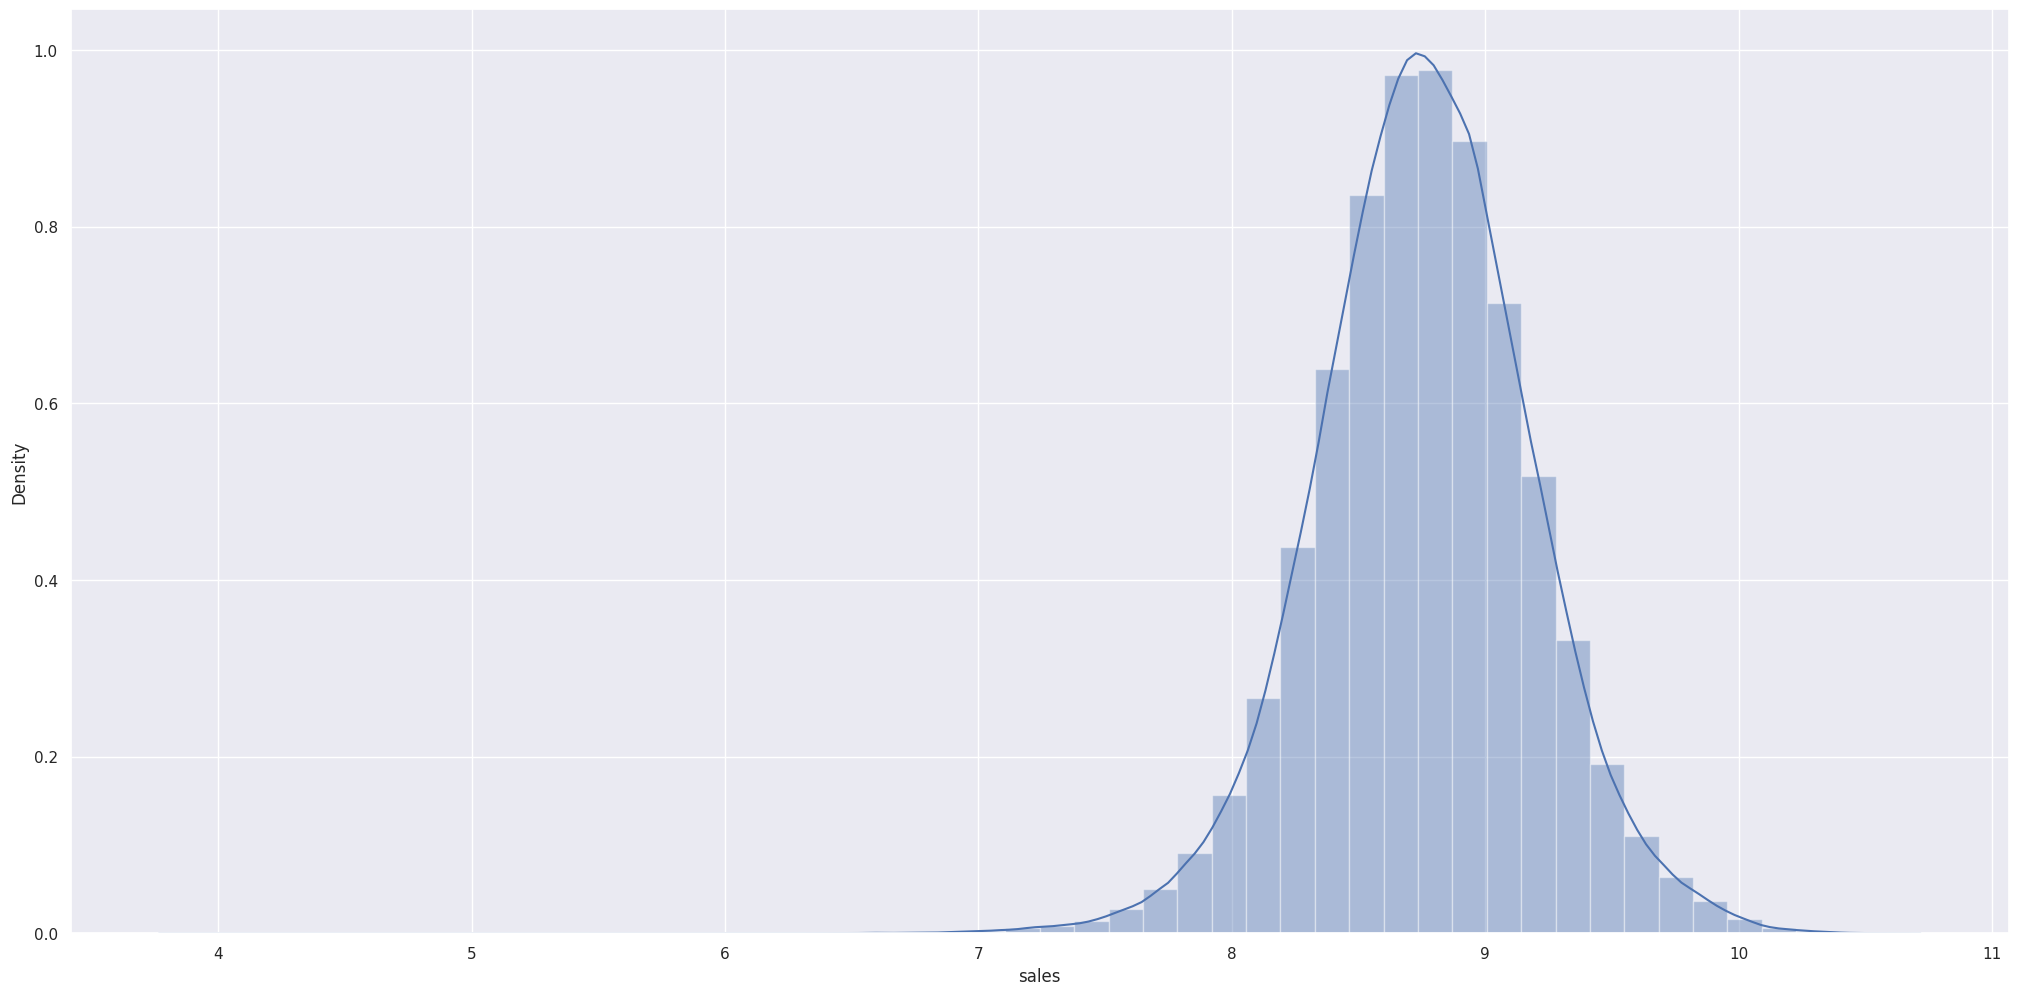

In [77]:
sns.distplot(df5['sales'])

### 5.3.2. Nature Transformation

In [78]:
df5.sample(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
655802,968,4,2013-11-21,9.135509,1,0,2,1,-0.183871,11,2013,0,47,2013,0,0.0,11,21,47,2013-46,2013-11-01,-0.216216,2013-11-18,0.287016,False,False,False,True
840872,948,6,2013-06-08,8.567506,0,0,1,2,-0.145161,6,2013,0,23,2013,0,0.0,6,8,23,2013-22,2013-06-01,-0.216216,2013-06-03,0.287016,False,False,False,True
1013228,479,5,2013-01-04,9.241742,0,1,0,1,-0.324194,12,2005,1,9,2011,0,0.0,1,4,1,2013-00,2005-12-01,0.945946,2011-02-21,0.507973,False,False,False,True
562109,935,4,2014-02-13,8.624791,0,0,0,3,3.229032,6,2010,0,7,2014,0,0.5,2,13,7,2014-06,2010-06-01,0.391892,2014-02-10,0.287016,False,False,False,True
595214,590,2,2014-01-14,8.187577,0,0,3,3,0.353226,9,2010,1,31,2013,1,0.5,1,14,3,2014-02,2010-09-01,0.337838,2013-07-29,0.341686,False,False,False,True


In [79]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7) ) )


# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52) ) )

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30) ) )

In [80]:
df5.sample(10)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos,month_sin,month_cos,day_sin,day_cos
89163,1079,3,2015-05-13,8.893298,0,0,0,1,2.314516,5,2015,1,37,2009,0,1.0,5,13,20,2015-19,2015-05-01,-0.216216,2009-09-07,0.961276,False,False,False,True,0.433884,-0.900969,6.631227e-01,-0.748511,5.000000e-01,-8.660254e-01,0.406737,-0.913545
194337,328,6,2015-02-07,7.857481,0,0,0,1,0.129032,7,2002,0,6,2015,0,1.0,2,7,6,2015-05,2002-07-01,1.851351,2015-02-02,0.287016,False,False,False,True,-0.781831,0.623490,6.631227e-01,0.748511,8.660254e-01,5.000000e-01,0.994522,0.104528
691778,149,6,2013-10-19,8.109526,0,0,3,1,0.045161,7,2006,1,14,2011,1,0.0,10,19,42,2013-41,2006-07-01,0.972973,2011-03-28,0.589977,False,False,False,True,-0.781831,0.623490,-9.350162e-01,0.354605,-8.660254e-01,5.000000e-01,-0.743145,-0.669131
725574,495,4,2013-09-19,8.193677,0,0,3,1,0.506452,9,2013,1,37,2009,0,0.0,9,19,38,2013-37,2013-09-01,-0.216216,2009-09-07,0.765376,False,False,False,True,-0.433884,-0.900969,-9.927089e-01,-0.120537,-1.000000e+00,-1.836970e-16,-0.743145,-0.669131
538394,635,4,2014-03-06,8.743851,1,0,0,1,4.064516,4,2014,0,10,2014,0,0.5,3,6,10,2014-09,2014-04-01,-0.229730,2014-03-03,0.287016,False,False,False,True,-0.433884,-0.900969,9.350162e-01,0.354605,1.000000e+00,6.123234e-17,0.951057,0.309017
880659,595,5,2013-05-03,9.772638,1,0,2,3,-0.193548,6,2015,0,18,2013,0,0.0,5,3,18,2013-17,2015-06-01,-0.567568,2013-04-29,0.287016,False,False,False,True,-0.974928,-0.222521,8.229839e-01,-0.568065,5.000000e-01,-8.660254e-01,0.587785,0.809017
410935,286,6,2014-06-28,7.702556,0,0,0,1,-0.140323,4,2015,0,26,2014,0,0.5,6,28,26,2014-25,2015-04-01,-0.351351,2014-06-23,0.287016,False,False,False,True,-0.781831,0.623490,1.224647e-16,-1.000000,1.224647e-16,-1.000000e+00,-0.406737,0.913545
54647,13,5,2015-06-12,8.172447,0,0,3,1,-0.325806,6,2015,1,45,2009,0,1.0,6,12,24,2015-23,2015-06-01,-0.216216,2009-11-02,0.952164,False,False,False,True,-0.974928,-0.222521,2.393157e-01,-0.970942,1.224647e-16,-1.000000e+00,0.587785,-0.809017
884757,233,1,2013-04-29,9.522593,1,0,0,1,-0.070968,4,2013,0,18,2013,0,0.0,4,29,18,2013-17,2013-04-01,-0.216216,2013-04-29,0.287016,False,False,False,True,0.781831,0.623490,8.229839e-01,-0.568065,8.660254e-01,-5.000000e-01,-0.207912,0.978148
701182,633,5,2013-10-11,8.945984,1,0,3,1,1.501613,4,2005,1,22,2011,1,0.0,10,11,41,2013-40,2005-04-01,1.175676,2011-05-23,0.569476,False,False,False,True,-0.974928,-0.222521,-9.709418e-01,0.239316,-8.660254e-01,5.000000e-01,0.743145,-0.669131
